In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#CREAZIONE GRAFICO SULLE PRIME 22 DIAGNOSI CON PIU PAZIENTI AFFETTI
############################################################################################
# Raggruppa per la colonna 'Description' e conta il numero di pazienti in ogni gruppo
df = pd.read_csv("Excel/Diagnostics.csv")
grouped = df.groupby('Description').size()

# Ordina i dati in ordine decrescente
top_22_descriptions = grouped.sort_values(ascending=False).head(22)

fig, ax = plt.subplots(figsize=(12,8))

# disegna il barplot
sns.barplot(
    x=top_22_descriptions.index,
    y=top_22_descriptions.values,
    hue=top_22_descriptions.index,
    palette="viridis",
    legend=False,
    ax=ax
)



# prendi le etichette originali, applica wrapping ogni 15 caratteri
wrapped = top_22_descriptions.index.to_series().str.wrap(55)

# impostale sull'asse x, con rotazione
ax.set_xticks(range(len(wrapped)))
ax.set_xticklabels(wrapped, rotation=45, ha='right')
ax.set_ylabel('Numero di pazienti', fontsize=16)
ax.set_xlabel('')  # niente label orizzontale

# Etichette numeriche
for i, v in enumerate(top_22_descriptions.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

print(top_22_descriptions)
############################################################################################

In [ ]:
#MERGE DELLE TABELLE Diagnostics.csv E Biochemical_parameters.csv E STAMPA DELLE STATISTICHE E
#DEI PAZIENTI CHE HANNO UNO SPECIFICA COMPLICAZIONE, IN QUESTO CASO: "Other and unspecified hyperlipidemia"
############################################################################################
diagnostics_df = pd.read_csv("Excel/Diagnostics.csv")
biochemical_df = pd.read_csv("Excel/Biochemical_parameters.csv")
# pivot dei parametri
bio_wide = biochemical_df.pivot_table(
    index="Patient_ID",
    columns="Name",
    values="Value",
    aggfunc="mean"
).reset_index()

# merge wide
merged_wide = pd.merge(
    diagnostics_df,
    bio_wide,
    on="Patient_ID",
    how="left"
)

#PRINT STATISTICHE
# print()
# print('numero di righe e colonne')
# print(merged_wide.shape)
# print()
# print('tipi e missing')
# print(merged_wide.info())
# print()
# print('statistiche numeriche di base')
# print(merged_wide.describe()) #viene eseguito solo sulle colonne numeriche es:int64
# print()


# filtri solo le righe con Description == 'Other and unspecified hyperlipidemia'
subset = merged_wide[ merged_wide['Description'] == 'Other and unspecified hyperlipidemia' ]


#PRINT DI QUANTI VALORI NULLI HA OGNI COLONNA DELLA TABELLA
print("VALORI NULLI")
nan_mask = subset.isna()
nan_count = nan_mask.sum()
print(nan_count)



#PRINT LISTA PAZIENTI CON QUESTA COMPLICAZIONE (Other and unspecified hyperlipidemia)
from IPython.display import display
display(subset)

############################################################################################

In [ ]:
#GRAFICI DI SESSO E ETA DEI PAZIENTI AFFETTI DA UNA CERTA COMPLICANZA, IN QUESTO CASO LA COMPLICANZA CON CODICE 272.4, OVVERO "Other and unspecified hyperlipidemia"
############################################################################################
diagnostics_df = pd.read_csv("Excel/Diagnostics.csv")
patient_df = pd.read_csv("Excel/Patient_info.csv")

#Merge dei dataset su Patient_ID
merged = pd.merge(
    diagnostics_df,
    patient_df,
    on="Patient_ID",
    how="left"
)

# STAMPA DEI CODICI CHE HANNO COME DESCRIZIONE DELLA PATOLOGIA "Other and unspecified hyperlipidemia"
# df_hp = merged[merged["Description"] == "Other and unspecified hyperlipidemia"].copy()
#
# print(df_hp["Code"].tolist())
# print("Codici unici:", df_hp["Code"].unique())
# print(df_hp[["Patient_ID","Code"]])


df_hp = merged[merged["Code"] == "272.4"].copy()

#calcola l'età (anno corrente 2025)
df_hp["Età"] = 2025 - df_hp["Birth_year"]

#Grafico distribuzione del sesso

light_blue = "#ADD8E6"   # “lightblue”
light_red  = "#FFB6C1"   # “lightpink”

# Conta e ordina (per sicurezza) i due valori
counts = df_hp["Sex"].value_counts()

# Definisci un dizionario di colori
color_map = {"M": light_blue, "F": light_red}
colors = [color_map[label] for label in counts.index]

# Pie‐chart con colori personalizzati
plt.figure(figsize=(6,6))
counts.plot.pie(
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    legend=False
)
plt.ylabel("")
plt.title("")
plt.axis("equal")
plt.tight_layout()
plt.show()

#Grafico distribuzione dell'età
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=df_hp,
    x="Età",
    fill=True,        # area sotto la curva colorata
    alpha=0.4,        # trasparenza
    linewidth=2
)
plt.title("")
plt.xlabel("Età")
plt.ylabel("Densità stimata")
plt.tight_layout()
plt.show()

#Istogramma con numero di pazienti per etá
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_hp,
    x="Età",
    bins=10,          # numero di barre (regola a piacere)
    stat="count",     # indica di mostrare conteggi anziché densità
    discrete=False    # False di default: barre continue
)
plt.xlabel("Età")
plt.ylabel("Numero di pazienti")
plt.tight_layout()
plt.show()
############################################################################################

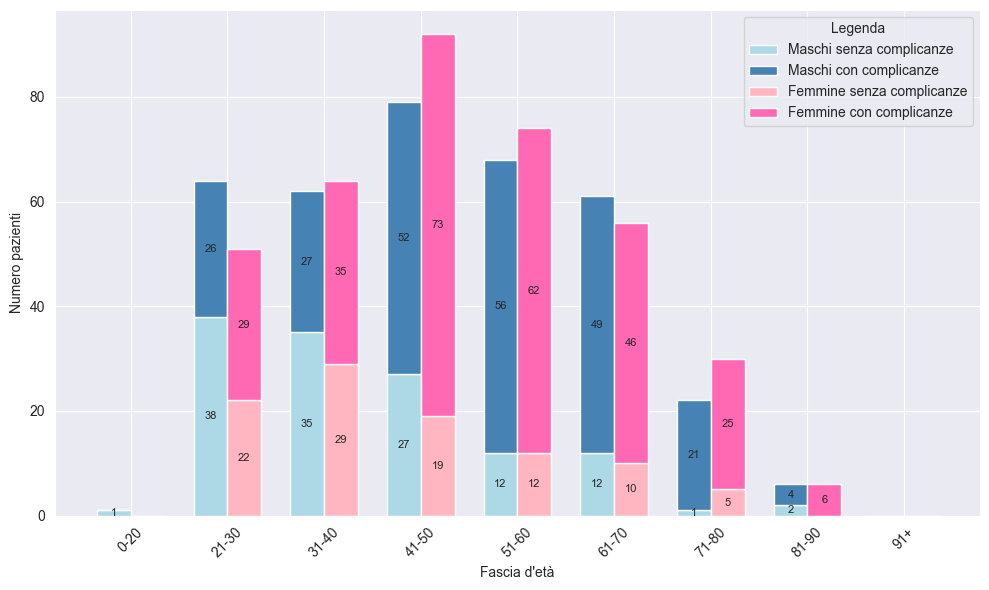

In [12]:
import numpy as np

#GRAFICO CHE MOSTRA LA DISTRIBUZIONE DI COMPLICANZE, SESSO ED ETA SU TUTTI I PAZIENTI
############################################################################################
# 1) Caricamento
diagnostics_df = pd.read_csv("Excel/Diagnostics.csv")
patient_df     = pd.read_csv("Excel/Patient_info.csv")

# 2) Costruisci il flag "has complication" ONE‑ROW‑PER‑PATIENT
diagnostics_df["Has_complication"] = diagnostics_df["Description"].notna()
complication_flag = (
    diagnostics_df
    .groupby("Patient_ID")["Has_complication"]
    .any()
    .reset_index()
)

# 3) Merge: UNA riga per paziente
merged = pd.merge(
    patient_df,
    complication_flag,
    on="Patient_ID",
    how="left"
)
# i pazienti senza diagnosi avranno NaN → False
merged["Has_complication"] = (
    merged["Has_complication"]
      .astype("boolean")      # diventa BooleanDtype (nullable)
      .fillna(False)          # i NaN diventano False, senza warning
)
merged["Complicanza"] = merged["Has_complication"].map({True:"Sì", False:"No"})

# verifica
assert len(merged) == 736, f"Righe in merged = {len(merged)} (attesi 736)"

# 4) Calcola età e fasce
merged["Eta"] = 2025 - merged["Birth_year"]
bins   = [0,20,30,40,50,60,70,80,90,120]
labels = ['0-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91+']
merged["Eta_bin"] = pd.cut(merged["Eta"], bins=bins, labels=labels, right=True)

# 5) Tabella di contingenza
table = (
    merged
    .groupby(["Eta_bin","Sex","Complicanza"], observed=True)
    .size()
    .unstack(fill_value=0)
)

# 6) Estrai M e F e reindicizza tutte le fasce
table_M = table.xs("M", level="Sex").reindex(labels, fill_value=0)
table_F = table.xs("F", level="Sex").reindex(labels, fill_value=0)

# 7) Prepara i vettori per il plot
x      = np.arange(len(labels))
width  = 0.35
no_M   = table_M["No"];   yes_M = table_M["Sì"]
no_F   = table_F["No"];   yes_F = table_F["Sì"]

colors = {
    'M_no':  '#ADD8E6',  # lightblue
    'M_yes': '#4682B4',  # steelblue
    'F_no':  '#FFB6C1',  # lightpink
    'F_yes': '#FF69B4',  # hotpink
}

# 8) Disegna il bar‑chart impilato
fig, ax = plt.subplots(figsize=(10,6))

bars_M_no  = ax.bar(x - width/2, no_M,  width, label='Maschi senza complicanze', color=colors['M_no'])
bars_M_yes = ax.bar(x - width/2, yes_M, width, bottom=no_M, label='Maschi con complicanze',    color=colors['M_yes'])
bars_F_no  = ax.bar(x + width/2, no_F,  width, label='Femmine senza complicanze', color=colors['F_no'])
bars_F_yes = ax.bar(x + width/2, yes_F, width, bottom=no_F, label='Femmine con complicanze',    color=colors['F_yes'])

# 9) Annotazioni dei valori dentro le barre
def annotate_bars(bars):
    for bar in bars:
        h = bar.get_height()
        if h>0:
            ax.annotate(f'{int(h)}',
                        xy=(bar.get_x()+bar.get_width()/2, bar.get_y()+h/2),
                        ha='center', va='center', fontsize=8)

for grp in (bars_M_no, bars_M_yes, bars_F_no, bars_F_yes):
    annotate_bars(grp)

# 10) Etichette e stile
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("Fascia d'età")
ax.set_ylabel("Numero pazienti")
ax.legend(title="Legenda")

plt.tight_layout()
plt.show()
############################################################################################

In [ ]:
from scipy.stats import mannwhitneyu
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# ANALISI TIR
############################################################################################
# ------------------------------------------------------------------------------------------------
# 1) CARICAMENTO DEI DATI
# ------------------------------------------------------------------------------------------------
df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")
parte1 = pd.read_csv("Excel/Parte1.csv")
# ------------------------------------------------------------------------------------------------
# 2) FUNZIONE PER CALCOLARE IL TIR DI UN PAZIENTE
#    Prende in ingresso il DataFrame delle misurazioni di un singolo paziente
# ------------------------------------------------------------------------------------------------
def calculate_tir(misurazioni):
    totale = len(misurazioni)  # numero totale di misurazioni
    righe_valide = misurazioni[
        (misurazioni['Measurement'] >= 70) &
        (misurazioni['Measurement'] <= 180)
    ]  # seleziona le misurazioni in range 70-180 mg/dL
    tir = len(righe_valide) / totale * 100  # percentuale Time In Range
    return tir

# ------------------------------------------------------------------------------------------------
# 3) CALCOLO TIR COMPLESSIVO PER OGNI PAZIENTE
#    Uso include_groups=False per evitare il DeprecationWarning
# ------------------------------------------------------------------------------------------------
pazienti = df.groupby('Patient_ID')
tir_by_paziente = pazienti.apply(
    calculate_tir,
    include_groups=False              # evita warning su grouping columns
).reset_index(name='%TIR')


# Stampa del DataFrame %TIR
print(tir_by_paziente)

# ------------------------------------------------------------------------------------------------
# 4) GRAFICO BAR PLOT PER %TIR DI OGNI PAZIENTE
# ------------------------------------------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.bar(tir_by_paziente['Patient_ID'], tir_by_paziente['%TIR'], color='skyblue')
plt.xticks([])  # nasconde le etichette X per chiarezza
plt.ylabel('% Time In Range (70–180 mg/dL)')
plt.xlabel('Pazienti')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TIR
print(tir_by_paziente['%TIR'].describe())

# ------------------------------------------------------------------------------------------------
# 5) RAGGRUPPAMENTO IN INTERVALLI E CONTEGGIO PAZIENTI
#    Uso observed=False per evitare il FutureWarning
# ------------------------------------------------------------------------------------------------
bins = [0, 1] + list(range(10, 110, 10))
tir_by_paziente['Interval'] = pd.cut(
    tir_by_paziente['%TIR'],
    bins=bins,
    right=False
)

# Flag per presenza di diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tir_by_paziente['Has_Diagnosis'] = tir_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Conteggio per ciascun intervallo e condizione
conta_per_interval = (
    tir_by_paziente
      .groupby(
          ['Interval', 'Has_Diagnosis'],
          observed=False              # evita warning su observed default
      )
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# ------------------------------------------------------------------------------------------------
# 6) ISTOGRAMMA A BARRE AFFIANCATE PER INTERVALLO
# ------------------------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = list(range(len(conta_per_interval)))

bar1 = plt.bar(
    [i - bar_width/2 for i in index],
    conta_per_interval[False],
    width=bar_width,
    label='Senza Complicanze',
    color='skyblue',
    edgecolor='black'
)
bar2 = plt.bar(
    [i + bar_width/2 for i in index],
    conta_per_interval[True],
    width=bar_width,
    label='Con Complicanze',
    color='lightcoral',
    edgecolor='black'
)

# Aggiunta etichette numeriche sopra le barre
for bars in (bar1, bar2):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2,
                h + 0.5,
                str(int(h)),
                ha='center', va='bottom', fontsize=9
            )

plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TIR')
plt.ylabel('Numero di Pazienti')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------------------------
# 7) TEST STATISTICO MANN–WHITNEY U
# ------------------------------------------------------------------------------------------------
g0 = tir_by_paziente.loc[~tir_by_paziente['Has_Diagnosis'], '%TIR']
g1 = tir_by_paziente.loc[ tir_by_paziente['Has_Diagnosis'], '%TIR']
u_stat, p_value = mannwhitneyu(g0, g1, alternative='two-sided')
print(f"U-statistic = {u_stat:.2f}")
print(f"p-value      = {p_value:.4f}")

# STATISTICHE PER GRUPPO
for nome_gruppo, gruppo in zip(["Senza Complicanze", "Con Complicanze"], [g0, g1]):
    media   = gruppo.mean()
    mediana = gruppo.median()
    q1      = gruppo.quantile(0.25)
    q3      = gruppo.quantile(0.75)
    iqr     = q3 - q1

    print(f"\nStatistiche per il gruppo '{nome_gruppo}':")
    print(f" - Media:   {media:.2f}")
    print(f" - Mediana: {mediana:.2f}")
    print(f" - IQR:     {iqr:.2f} (Q3: {q3:.2f}, Q1: {q1:.2f})")

# ------------------------------------------------------------------------------------------------
# 8) STATISTICHE AGGIUNTIVE: MEDIA, MEDIANA, ASIMMETRIA, CURTOSI, OUTLIER, MODA
# ------------------------------------------------------------------------------------------------
tir_values = tir_by_paziente['%TIR']
media    = tir_values.mean()
mediana  = tir_values.median()
asim     = skew(tir_values)
curto    = kurtosis(tir_values)
moda     = tir_values.round().mode()
q1, q3   = tir_values.quantile([0.25, 0.75])
iqr      = q3 - q1
outliers = tir_values[
    (tir_values < q1 - 1.5 * iqr) |
    (tir_values > q3 + 1.5 * iqr)
]

print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asim:.2f}")
print(f"Curtosi (kurtosis): {curto:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())

q1_total, q3_total = tir_values.quantile([0.25, 0.75])
iqr_total = q3_total - q1_total
print(f"Q1:  {q1_total:.2f}")
print(f"Q3:  {q3_total:.2f}")
print(f"IQR: {iqr_total:.2f}")

# ------------------------------------------------------------------------------------------------
# 9) CALCOLO TIR SUI PRIMI 3 MESI
# ------------------------------------------------------------------------------------------------
df['Measurement_date'] = pd.to_datetime(df['Measurement_date']) # trasforma la colonna Measurement_date del glucosio in oggetti datetime
first_dates = df.groupby('Patient_ID')['Measurement_date'].min().rename('FirstDate')    # per ogni paziente calcola la data della prima misurazione
df = df.join(first_dates, on='Patient_ID')  # aggiunge al dataset di partenza la colonna che indica la prima data di misurazione del glucosio

df_3m = df[df['Measurement_date'] <= df['FirstDate'] + pd.DateOffset(months=3)] #crea un sotto-dataset che cotiene solo le righe in cui la data di misurazione é ≤ (prima data + 3 mesi)
pazienti_3m = df_3m.groupby('Patient_ID')   # ragruppa il risultato per paziente
tir3m_by_paziente = pazienti_3m.apply(      # sul dataset ottenuto che contiene solo i primi 3 mesi di misurazioni per paziente calcola il TIR e lo aggiunge come colonna
    calculate_tir,
    include_groups=False              # evita warning anche qui
).reset_index(name='%TIR_3m')

# Al dataset aggiunge anche il campo Has_Diagnosis che indica se il paziente ha o meno una complicanza
tir3m_by_paziente['Has_Diagnosis'] = tir3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)
tir3m_by_paziente['Interval'] = pd.cut(     # raggruppa i valori di TIR in intervalli da 10
    tir3m_by_paziente['%TIR_3m'],
    bins=bins,
    right=False
)


conta_per_interval_3m = (
    tir3m_by_paziente
      .groupby(
          ['Interval', 'Has_Diagnosis'],
          observed=False              # evita FutureWarning anche qui
      )
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# Istogramma primi 3 mesi
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = list(range(len(conta_per_interval_3m)))

bar1_3m = plt.bar(
    [i - bar_width/2 for i in index_3m],
    conta_per_interval_3m[False],
    width=bar_width,
    label='Senza Complicanze', edgecolor='black', color='skyblue',
)
bar2_3m = plt.bar(
    [i + bar_width/2 for i in index_3m],
    conta_per_interval_3m[True],
    width=bar_width,
    label='Con Complicanze', edgecolor='black', color='lightcoral',
)
for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5,
                     str(int(h)), ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TIR_3m')
plt.ylabel('Numero di Pazienti')
plt.legend()
plt.tight_layout()
plt.show()

# Statistiche descrittive %TIR_3m
print(tir3m_by_paziente['%TIR_3m'].describe())


# ------------------------------------------------------------------------------------------------
# 10) CALCOLO TIR SUGLI ULTIMI 3 MESI
# ------------------------------------------------------------------------------------------------
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])  # datetime
# Calcolo per ogni paziente la data dell'ultima misurazione
last_dates = df.groupby('Patient_ID')['Measurement_date'].max().rename('LastDate')
# Aggiungo la colonna LastDate al dataset
df = df.join(last_dates, on='Patient_ID')

# Filtro alle righe in cui la data di misurazione è ≥ (ultima data - 3 mesi)
df_last3m = df[df['Measurement_date'] >= df['LastDate'] - pd.DateOffset(months=3)]
# Raggruppo per paziente
pazienti_last3m = df_last3m.groupby('Patient_ID')

# Calcolo %TIR sugli ultimi 3 mesi per ciascun paziente
tir_last3m_by_paziente = pazienti_last3m.apply(
    calculate_tir,
    include_groups=False
).reset_index(name='%TIR_last3m')

# Merge sul Patient_ID
parte1 = parte1.merge(
    tir_last3m_by_paziente[['Patient_ID', '%TIR_last3m']],
    on='Patient_ID',
    how='left',
    validate='one_to_one'    # assicura che ogni paziente appaia una sola volta in entrambi
)

# Controlla eventuali pazienti senza misurazioni negli ultimi 3 mesi
missing_l3m = parte1['%TIR_last3m'].isna().sum()
if missing_l3m > 0:
    print(f"Attenzione: {missing_l3m} pazienti non hanno misurazioni negli ultimi 3 mesi e avranno %TIR_last3m=NaN")

# Salva il risultato senza formattazione particolare
parte1.to_csv("Excel/Parte1.csv", index=False)
print("Aggiornato Excel/Parte1.csv con la colonna %TIR_last3m.")




# Aggiungo flag complicanze e fasce di %TIR
tir_last3m_by_paziente['Has_Diagnosis'] = tir_last3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)
tir_last3m_by_paziente['Interval'] = pd.cut(
    tir_last3m_by_paziente['%TIR_last3m'],
    bins=bins,
    right=False
)

# Conteggio per intervallo e condizione
conta_per_interval_last3m = (
    tir_last3m_by_paziente
      .groupby(['Interval', 'Has_Diagnosis'], observed=False)
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# Istogramma ultimi 3 mesi
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_l3m = range(len(conta_per_interval_last3m))

bar1_l3m = plt.bar(
    [i - bar_width/2 for i in index_l3m],
    conta_per_interval_last3m[False],
    width=bar_width,
    label='Senza Complicanze', edgecolor='black', color='skyblue'
)
bar2_l3m = plt.bar(
    [i + bar_width/2 for i in index_l3m],
    conta_per_interval_last3m[True],
    width=bar_width,
    label='Con Complicanze', edgecolor='black', color='lightcoral'
)
for bars in (bar1_l3m, bar2_l3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2,
                h + 0.5,
                str(int(h)),
                ha='center', va='bottom', fontsize=9
            )

plt.xticks(index_l3m, [str(i) for i in conta_per_interval_last3m.index], rotation=45)
plt.xlabel('%TIR_last3m')
plt.ylabel('Numero di Pazienti')
plt.legend()
plt.tight_layout()
plt.show()

# Statistiche descrittive %TIR_last3m
print(tir_last3m_by_paziente['%TIR_last3m'].describe())


# ------------------------------------------------------------------------------------------------
# 11) TEST STATISTICO MANN–WHITNEY U: confronto TIR primi 3 mesi vs ultimi 3 mesi
# ------------------------------------------------------------------------------------------------
from scipy.stats import mannwhitneyu

# Estrazione delle due distribuzioni
tir_first3m = tir3m_by_paziente['%TIR_3m']
tir_last3m  = tir_last3m_by_paziente['%TIR_last3m']

# Mann–Whitney U test (two-sided)
u_stat_3m, p_value_3m = mannwhitneyu(tir_first3m, tir_last3m, alternative='two-sided')

print("Confronto TIR Primi 3 Mesi vs Ultimi 3 Mesi")
print(f" U-statistic = {u_stat_3m:.2f}")
print(f" p-value      = {p_value_3m:.4f}")

# Eventuale interpretazione
alpha = 0.05
if p_value_3m < alpha:
    print("→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).")
else:
    print("→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).")


############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import mannwhitneyu

df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

# ANALISI TAR
############################################################################################
# Funzione per calcolare il TAR di un paziente
def calculate_tar(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] > 180)] # Seleziona solo le righe che nel campo Measurement hanno un valore maggiore di 180 mg/dL
    tar = len(righe_valide)/totale * 100 # Calcola il %TAR facendo Misurazioni Valide/Misurazioni Totali
    return tar

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tar_by_paziente = pazienti.apply(calculate_tar,include_groups=False ).reset_index(name='%TAR') # Calcoliamo il TAR di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TAR
# tar_by_paziente = tar_by_paziente.sort_values(by='%TAR', ascending=False)

print(tar_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tar_by_paziente['Patient_ID'], tar_by_paziente['%TAR'], color='skyblue')
plt.xticks([])
plt.ylabel('% Time Above Range (> 180 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TAR
print(tar_by_paziente['%TAR'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tar_intervals = pd.cut(tar_by_paziente['%TAR'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tar_by_paziente['Has_Diagnosis'] = tar_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tar_by_paziente['Interval'] = tar_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tar_by_paziente.groupby(['Interval', 'Has_Diagnosis'],observed=False  ).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()

# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TAR')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()



tar_values = tar_by_paziente['%TAR']

# Statistiche descrittive
media = tar_values.mean()
mediana = tar_values.median()
asimmetria = skew(tar_values) #skewness
curtosi = kurtosis(tar_values)

tar_arrotondato = tar_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tar_values.quantile(0.25)
q3 = tar_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tar_values[(tar_values < lower_thr) | (tar_values > upper_thr)]
print("Valori TAR considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())


# Estrai le due serie
g0 = tar_by_paziente.loc[ tar_by_paziente['Has_Diagnosis']==False, '%TAR']
g1 = tar_by_paziente.loc[ tar_by_paziente['Has_Diagnosis']==True,  '%TAR']

# Esegui il test two-sided
u_stat, p_value = mannwhitneyu(g0, g1, alternative='two-sided')

print(f"U-statistic = {u_stat:.2f}")
print(f"p-value      = {p_value:.4f}")

# STATISTICHE PER GRUPPO
for nome_gruppo, gruppo in zip(["Senza Complicanze", "Con Complicanze"], [g0, g1]):
    media   = gruppo.mean()
    mediana = gruppo.median()
    q1      = gruppo.quantile(0.25)
    q3      = gruppo.quantile(0.75)
    iqr     = q3 - q1

    print(f"\nStatistiche per il gruppo '{nome_gruppo}':")
    print(f" - Media:   {media:.2f}")
    print(f" - Mediana: {mediana:.2f}")
    print(f" - IQR:     {iqr:.2f} (Q3: {q3:.2f}, Q1: {q1:.2f})")
############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# ANALISI TAR LV1
############################################################################################

parte1 = pd.read_csv("Excel/Parte1.csv")
df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

# Funzione per calcolare il TARLV1 di un paziente
def calculate_tar(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] >= 181) & (misurazioni['Measurement'] <= 249)] # Seleziona solo le righe che nel campo Measurement hanno un valore compreso tra 181 e 249 mg/dL
    tar = len(righe_valide)/totale * 100 # Calcola il %TARLV1 facendo Misurazioni Valide/Misurazioni Totali
    return tar

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tar_by_paziente = pazienti.apply(calculate_tar, include_groups=False).reset_index(name='%TARLV1') # Calcoliamo il TARLV1 di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TARLV1
# tar_by_paziente = tar_by_paziente.sort_values(by='%TARLV1', ascending=False)

print(tar_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tar_by_paziente['Patient_ID'], tar_by_paziente['%TARLV1'], color='#ffa07a')
plt.xticks([])
plt.ylabel('% Time Above Range LV1 (181 - 249 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TARLV1
print(tar_by_paziente['%TARLV1'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tar_intervals = pd.cut(tar_by_paziente['%TARLV1'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tar_by_paziente['Has_Diagnosis'] = tar_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tar_by_paziente['Interval'] = tar_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tar_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()


# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TARLV1')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()


tar_values = tar_by_paziente['%TARLV1']

# Statistiche descrittive
media = tar_values.mean()
mediana = tar_values.median()
asimmetria = skew(tar_values) #skewness
curtosi = kurtosis(tar_values)

tar_arrotondato = tar_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tar_values.quantile(0.25)
q3 = tar_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tar_values[(tar_values < lower_thr) | (tar_values > upper_thr)]
print("Valori TARLV1 considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())

# ------------------------------------------------------------------------------------------------
# CALCOLO TAR SUI PRIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo la prima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].min().rename('FirstDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data iniziale
df_3m = df[df['Measurement_date'] <= df['FirstDate'] + pd.DateOffset(months=3)]

# 4) Calcolo il TIR sui primi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tar3m_by_paziente = pazienti_3m.apply(calculate_tar, include_groups=False ).reset_index(name='%TARLV1_3m')

# 5) Aggiungo il flag di diagnosi
tar3m_by_paziente['Has_Diagnosis'] = tar3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tar3m_by_paziente['Interval'] = pd.cut(tar3m_by_paziente['%TARLV1_3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tar3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TARLV1_3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tar3m_by_paziente['%TARLV1_3m'].describe())



# ------------------------------------------------------------------------------------------------
# CALCOLO TAR SUGLI ULTIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo l'ultima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].max().rename('LastDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data finale
df_3m = df[df['Measurement_date'] >= df['LastDate'] - pd.DateOffset(months=3)]

# 4) Calcolo il TIR sugli ultimi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tar_last3m_by_paziente = pazienti_3m.apply(calculate_tar, include_groups=False ).reset_index(name='%TARLV1_last3m')

# Merge con i valori %TARLV1_last3m calcolati
parte1 = parte1.merge(
    tar_last3m_by_paziente[['Patient_ID', '%TARLV1_last3m']],
    on='Patient_ID',
    how='left',
    validate='one_to_one'  # verifica che non ci siano duplicati
)

# Opzionale: controlla quanti pazienti non hanno %TARLV1_last3m (nessuna misurazione negli ultimi 3 mesi)
missing = parte1['%TARLV1_last3m'].isna().sum()
print(f"Attenzione: {missing} pazienti non hanno misurazioni negli ultimi 3 mesi.")

# Salva il dataset aggiornato
parte1.to_csv("Excel/Parte1.csv", index=False)
print("✅ Salvato 'Excel/Parte1.csv' con la nuova colonna '%TARLV1_last3m'.")

# 5) Aggiungo il flag di diagnosi
tar_last3m_by_paziente['Has_Diagnosis'] = tar_last3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tar_last3m_by_paziente['Interval'] = pd.cut(tar_last3m_by_paziente['%TARLV1_last3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tar_last3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TARLV1_last3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tar_last3m_by_paziente['%TARLV1_last3m'].describe())


# ------------------------------------------------------------------------------------------------
# TEST STATISTICO MANN–WHITNEY U: confronto TAR primi 3 mesi vs ultimi 3 mesi
# ------------------------------------------------------------------------------------------------
from scipy.stats import mannwhitneyu

# Estrazione delle due distribuzioni
tar_first3m = tar3m_by_paziente['%TARLV1_3m']
tar_last3m  = tar_last3m_by_paziente['%TARLV1_last3m']

# Mann–Whitney U test (two-sided)
u_stat_3m, p_value_3m = mannwhitneyu(tar_first3m, tar_last3m, alternative='two-sided')

print("Confronto TAR Primi 3 Mesi vs Ultimi 3 Mesi")
print(f" U-statistic = {u_stat_3m:.2f}")
print(f" p-value      = {p_value_3m:.4f}")

# Eventuale interpretazione
alpha = 0.05
if p_value_3m < alpha:
    print("→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).")
else:
    print("→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).")

############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")
parte1 = pd.read_csv("Excel/Parte1.csv")

# ANALISI TAR LV2
############################################################################################
# Funzione per calcolare il TARLV2 di un paziente
def calculate_tar(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] >= 250)] # Seleziona solo le righe che nel campo Measurement hanno un valore maggiore di 250 mg/dL
    tar = len(righe_valide)/totale * 100 # Calcola il %TARLV2 facendo Misurazioni Valide/Misurazioni Totali
    return tar

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tar_by_paziente = pazienti.apply(calculate_tar, include_groups=False).reset_index(name='%TARLV2') # Calcoliamo il TARLV2 di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TARLV2
# tar_by_paziente = tar_by_paziente.sort_values(by='%TARLV2', ascending=False)

print(tar_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tar_by_paziente['Patient_ID'], tar_by_paziente['%TARLV2'], color='#e64100')
plt.xticks([])
plt.ylabel('% Time Above Range LV2 (> 249 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TARLV2
print(tar_by_paziente['%TARLV2'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tar_intervals = pd.cut(tar_by_paziente['%TARLV2'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tar_by_paziente['Has_Diagnosis'] = tar_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tar_by_paziente['Interval'] = tar_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tar_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()

# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TARLV2')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()


tar_values = tar_by_paziente['%TARLV2']

# Statistiche descrittive
media = tar_values.mean()
mediana = tar_values.median()
asimmetria = skew(tar_values) #skewness
curtosi = kurtosis(tar_values)

tar_arrotondato = tar_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tar_values.quantile(0.25)
q3 = tar_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tar_values[(tar_values < lower_thr) | (tar_values > upper_thr)]
print("Valori TARLV2 considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())


# ------------------------------------------------------------------------------------------------
# CALCOLO TAR SUI PRIMI 3 MESI
# ------------------------------------------------------------------------------------------------


# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo la prima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].min().rename('FirstDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data iniziale
df_3m = df[df['Measurement_date'] <= df['FirstDate'] + pd.DateOffset(months=3)]

# 4) Calcolo il TIR sui primi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tar3m_by_paziente = pazienti_3m.apply(calculate_tar, include_groups=False).reset_index(name='%TARLV2_3m')

# 5) Aggiungo il flag di diagnosi
tar3m_by_paziente['Has_Diagnosis'] = tar3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tar3m_by_paziente['Interval'] = pd.cut(tar3m_by_paziente['%TARLV2_3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tar3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TARLV2_3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tar3m_by_paziente['%TARLV2_3m'].describe())


# ------------------------------------------------------------------------------------------------
# CALCOLO TAR SUGLI ULTIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo l'ultima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].max().rename('LastDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data finale
df_3m = df[df['Measurement_date'] >= df['LastDate'] - pd.DateOffset(months=3)]

# 4) Calcolo il TIR sugli ultimi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tar_last3m_by_paziente = pazienti_3m.apply(calculate_tar, include_groups=False ).reset_index(name='%TARLV2_last3m')

# Merge con i valori %TARLV2_last3m calcolati
parte1 = parte1.merge(
    tar_last3m_by_paziente[['Patient_ID', '%TARLV2_last3m']],
    on='Patient_ID',
    how='left',
    validate='one_to_one'  # Assicura corrispondenza 1-a-1
)

# Controllo eventuali NaN
missing = parte1['%TARLV2_last3m'].isna().sum()
print(f"Attenzione: {missing} pazienti non hanno misurazioni per il calcolo del TAR livello 2 negli ultimi 3 mesi.")

# Salvataggio del dataset aggiornato
parte1.to_csv("Excel/Parte1.csv", index=False)
print("✅ Salvato 'Excel/Parte1.csv' con la nuova colonna '%TARLV2_last3m'.")

# 5) Aggiungo il flag di diagnosi
tar_last3m_by_paziente['Has_Diagnosis'] = tar_last3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tar_last3m_by_paziente['Interval'] = pd.cut(tar_last3m_by_paziente['%TARLV2_last3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tar_last3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TARLV2_last3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tar_last3m_by_paziente['%TARLV2_last3m'].describe())


# ------------------------------------------------------------------------------------------------
# TEST STATISTICO MANN–WHITNEY U: confronto TAR primi 3 mesi vs ultimi 3 mesi
# ------------------------------------------------------------------------------------------------
from scipy.stats import mannwhitneyu

# Estrazione delle due distribuzioni
tar_first3m = tar3m_by_paziente['%TARLV2_3m']
tar_last3m  = tar_last3m_by_paziente['%TARLV2_last3m']

# Mann–Whitney U test (two-sided)
u_stat_3m, p_value_3m = mannwhitneyu(tar_first3m, tar_last3m, alternative='two-sided')

print("Confronto TAR Primi 3 Mesi vs Ultimi 3 Mesi")
print(f" U-statistic = {u_stat_3m:.2f}")
print(f" p-value      = {p_value_3m:.4f}")

# Eventuale interpretazione
alpha = 0.05
if p_value_3m < alpha:
    print("→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).")
else:
    print("→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).")
############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import mannwhitneyu

df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

# ANALISI TBR
############################################################################################
# Funzione per calcolare il TBR di un paziente
def calculate_tbr(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] < 70)] # Seleziona solo le righe che nel campo Measurement hanno un valore minore di 70 mg/dL
    tbr = len(righe_valide)/totale * 100 # Calcola il %TBR facendo Misurazioni Valide/Misurazioni Totali
    return tbr

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tbr_by_paziente = pazienti.apply(calculate_tbr, include_groups=False).reset_index(name='%TBR') # Calcoliamo il TBR di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TBR
# tbr_by_paziente = tbr_by_paziente.sort_values(by='%TBR', ascending=False)
print(tbr_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tbr_by_paziente['Patient_ID'], tbr_by_paziente['%TBR'], color='skyblue')
plt.xticks([])
plt.ylabel('% Time Below Range (< 70 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TBR
print(tbr_by_paziente['%TBR'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tbr_intervals = pd.cut(tbr_by_paziente['%TBR'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tbr_by_paziente['Has_Diagnosis'] = tbr_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tbr_by_paziente['Interval'] = tbr_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tbr_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()


# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TBR')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()



tbr_values = tbr_by_paziente['%TBR']

# Statistiche descrittive
media = tbr_values.mean()
mediana = tbr_values.median()
asimmetria = skew(tbr_values) #skewness
curtosi = kurtosis(tbr_values)

tar_arrotondato = tbr_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tbr_values.quantile(0.25)
q3 = tbr_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tbr_values[(tbr_values < lower_thr) | (tbr_values > upper_thr)]
print("Valori TBR considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())

# Estrai le due serie
g0 = tbr_by_paziente.loc[ tbr_by_paziente['Has_Diagnosis']==False, '%TBR']
g1 = tbr_by_paziente.loc[ tbr_by_paziente['Has_Diagnosis']==True,  '%TBR']

# Esegui il test two-sided
u_stat, p_value = mannwhitneyu(g0, g1, alternative='two-sided')

# STATISTICHE PER GRUPPO
for nome_gruppo, gruppo in zip(["Senza Complicanze", "Con Complicanze"], [g0, g1]):
    media   = gruppo.mean()
    mediana = gruppo.median()
    q1      = gruppo.quantile(0.25)
    q3      = gruppo.quantile(0.75)
    iqr     = q3 - q1

    print(f"\nStatistiche per il gruppo '{nome_gruppo}':")
    print(f" - Media:   {media:.2f}")
    print(f" - Mediana: {mediana:.2f}")
    print(f" - IQR:     {iqr:.2f} (Q3: {q3:.2f}, Q1: {q1:.2f})")

print(f"U-statistic = {u_stat:.2f}")
print(f"p-value      = {p_value:.4f}")
############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

parte1 = pd.read_csv("Excel/Parte1.csv")
df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

# ANALISI TBR LV1
############################################################################################
# Funzione per calcolare il TBRLV1 di un paziente
def calculate_tbr(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] >= 54) & (misurazioni['Measurement'] < 70)] # Seleziona solo le righe che nel campo Measurement hanno un valore compreso tra 54 e 70 mg/dL
    tbr = len(righe_valide)/totale * 100 # Calcola il %TBRLV1 facendo Misurazioni Valide/Misurazioni Totali
    return tbr

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tbr_by_paziente = pazienti.apply(calculate_tbr, include_groups=False ).reset_index(name='%TBRLV1') # Calcoliamo il TBRLV1 di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TBRLV1
# tbr_by_paziente = tbr_by_paziente.sort_values(by='%TBRLV1', ascending=False)

print(tbr_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tbr_by_paziente['Patient_ID'], tbr_by_paziente['%TBRLV1'], color='#ffa07a')
plt.xticks([])
plt.ylabel('% Time Below Range (54 - 70 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TBRLV1
print(tbr_by_paziente['%TBRLV1'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tbr_intervals = pd.cut(tbr_by_paziente['%TBRLV1'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tbr_by_paziente['Has_Diagnosis'] = tbr_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tbr_by_paziente['Interval'] = tbr_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tbr_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()

# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TBRLV1')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()


tbr_values = tbr_by_paziente['%TBRLV1']

# Statistiche descrittive
media = tbr_values.mean()
mediana = tbr_values.median()
asimmetria = skew(tbr_values) #skewness
curtosi = kurtosis(tbr_values)

tar_arrotondato = tbr_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tbr_values.quantile(0.25)
q3 = tbr_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tbr_values[(tbr_values < lower_thr) | (tbr_values > upper_thr)]
print("Valori TBRLV1 considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())


# ------------------------------------------------------------------------------------------------
# CALCOLO TBR SUI PRIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo la prima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].min().rename('FirstDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data iniziale
df_3m = df[df['Measurement_date'] <= df['FirstDate'] + pd.DateOffset(months=3)]

# 4) Calcolo il TIR sui primi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tbr3m_by_paziente = pazienti_3m.apply(calculate_tbr, include_groups=False).reset_index(name='%TBRLV1_3m')

# 5) Aggiungo il flag di diagnosi
tbr3m_by_paziente['Has_Diagnosis'] = tbr3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tbr3m_by_paziente['Interval'] = pd.cut(tbr3m_by_paziente['%TBRLV1_3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tbr3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TBRLV1_3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tbr3m_by_paziente['%TBRLV1_3m'].describe())



# ------------------------------------------------------------------------------------------------
# CALCOLO TBR SUGLI ULTIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo l'ultima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].max().rename('LastDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data finale
df_3m = df[df['Measurement_date'] >= df['LastDate'] - pd.DateOffset(months=3)]

# 4) Calcolo il TIR sugli ultimi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tbr_last3m_by_paziente = pazienti_3m.apply(calculate_tbr, include_groups=False).reset_index(name='%TBRLV1_last3m')

# Merge con i valori %TBRLV1_last3m calcolati
parte1 = parte1.merge(
    tbr_last3m_by_paziente[['Patient_ID', '%TBRLV1_last3m']],
    on='Patient_ID',
    how='left',
    validate='one_to_one'  # Assicura che ogni paziente compaia una sola volta
)

# Controllo eventuali NaN
missing = parte1['%TBRLV1_last3m'].isna().sum()
print(f"Attenzione: {missing} pazienti non hanno misurazioni per il calcolo del TBR livello 1 negli ultimi 3 mesi.")

# Salvataggio del dataset aggiornato
parte1.to_csv("Excel/Parte1.csv", index=False)
print("✅ Salvato 'Excel/Parte1.csv' con la nuova colonna '%TBRLV1_last3m'.")

# 5) Aggiungo il flag di diagnosi
tbr_last3m_by_paziente['Has_Diagnosis'] = tbr_last3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tbr_last3m_by_paziente['Interval'] = pd.cut(tbr_last3m_by_paziente['%TBRLV1_last3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tbr_last3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TBRLV1_last3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tbr_last3m_by_paziente['%TBRLV1_last3m'].describe())


# ------------------------------------------------------------------------------------------------
# TEST STATISTICO MANN–WHITNEY U: confronto TBR primi 3 mesi vs ultimi 3 mesi
# ------------------------------------------------------------------------------------------------
from scipy.stats import mannwhitneyu

# Estrazione delle due distribuzioni
tbr_first3m = tbr3m_by_paziente['%TBRLV1_3m']
tbr_last3m  = tbr_last3m_by_paziente['%TBRLV1_last3m']

# Mann–Whitney U test (two-sided)
u_stat_3m, p_value_3m = mannwhitneyu(tbr_first3m, tbr_last3m, alternative='two-sided')

print("Confronto TBR Primi 3 Mesi vs Ultimi 3 Mesi")
print(f" U-statistic = {u_stat_3m:.2f}")
print(f" p-value      = {p_value_3m:.4f}")

# Eventuale interpretazione
alpha = 0.05
if p_value_3m < alpha:
    print("→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).")
else:
    print("→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).")
############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")
parte1 = pd.read_csv("Excel/Parte1.csv")

# ANALISI TBR LV2
############################################################################################
# Funzione per calcolare il TBRLV2 di un paziente
def calculate_tbr(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] < 54)] # Seleziona solo le righe che nel campo Measurement hanno un valore minore di 54 mg/dL
    tbr = len(righe_valide)/totale * 100 # Calcola il %TBRLV2 facendo Misurazioni Valide/Misurazioni Totali
    return tbr

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tbr_by_paziente = pazienti.apply(calculate_tbr, include_groups=False).reset_index(name='%TBRLV2') # Calcoliamo il TBRLV2 di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TBRLV2
# tbr_by_paziente = tbr_by_paziente.sort_values(by='%TBRLV2', ascending=False)

print(tbr_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tbr_by_paziente['Patient_ID'], tbr_by_paziente['%TBRLV2'], color='#e64100')
plt.xticks([])
plt.ylabel('% Time Below Range (< 54 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TBRLV2
print(tbr_by_paziente['%TBRLV2'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tbr_intervals = pd.cut(tbr_by_paziente['%TBRLV2'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tbr_by_paziente['Has_Diagnosis'] = tbr_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tbr_by_paziente['Interval'] = tbr_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tbr_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()

# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TBRLV2')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()


tbr_values = tbr_by_paziente['%TBRLV2']

# Statistiche descrittive
media = tbr_values.mean()
mediana = tbr_values.median()
asimmetria = skew(tbr_values) #skewness
curtosi = kurtosis(tbr_values)

tar_arrotondato = tbr_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tbr_values.quantile(0.25)
q3 = tbr_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tbr_values[(tbr_values < lower_thr) | (tbr_values > upper_thr)]
print("Valori TBRLV2 considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())



# ------------------------------------------------------------------------------------------------
# CALCOLO TBR SUI PRIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo la prima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].min().rename('FirstDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data iniziale
df_3m = df[df['Measurement_date'] <= df['FirstDate'] + pd.DateOffset(months=3)]

# 4) Calcolo il TIR sui primi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tbr3m_by_paziente = pazienti_3m.apply(calculate_tbr, include_groups=False).reset_index(name='%TBRLV2_3m')

# 5) Aggiungo il flag di diagnosi
tbr3m_by_paziente['Has_Diagnosis'] = tbr3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tbr3m_by_paziente['Interval'] = pd.cut(tbr3m_by_paziente['%TBRLV2_3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tbr3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TBRLV2_3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tbr3m_by_paziente['%TBRLV2_3m'].describe())



# ------------------------------------------------------------------------------------------------
# CALCOLO TBR SUGLI ULTIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo l'ultima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].max().rename('LastDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data finale
df_3m = df[df['Measurement_date'] >= df['LastDate'] - pd.DateOffset(months=3)]

# 4) Calcolo il TIR sugli ultimi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tbr_last3m_by_paziente = pazienti_3m.apply(calculate_tbr, include_groups=False).reset_index(name='%TBRLV2_last3m')

# Merge con i valori %TBRLV2_last3m calcolati
parte1 = parte1.merge(
    tbr_last3m_by_paziente[['Patient_ID', '%TBRLV2_last3m']],
    on='Patient_ID',
    how='left',
    validate='one_to_one'
)

# Controllo eventuali pazienti senza misurazioni sufficienti
missing = parte1['%TBRLV2_last3m'].isna().sum()
print(f"ℹ️  {missing} pazienti non hanno misurazioni sufficienti per il calcolo del TBR livello 2 negli ultimi 3 mesi.")

# Salvataggio del file aggiornato
parte1.to_csv("Excel/Parte1.csv", index=False)
print("✅ Salvato 'Excel/Parte1.csv' con la nuova colonna '%TBRLV2_last3m'.")

# 5) Aggiungo il flag di diagnosi
tbr_last3m_by_paziente['Has_Diagnosis'] = tbr_last3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tbr_last3m_by_paziente['Interval'] = pd.cut(tbr_last3m_by_paziente['%TBRLV2_last3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tbr_last3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TBRLV2_last3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tbr_last3m_by_paziente['%TBRLV2_last3m'].describe())
############################################################################################
############################################################################################


# ------------------------------------------------------------------------------------------------
# TEST STATISTICO MANN–WHITNEY U: confronto TBR primi 3 mesi vs ultimi 3 mesi
# ------------------------------------------------------------------------------------------------
from scipy.stats import mannwhitneyu

# Estrazione delle due distribuzioni
tbr_first3m = tbr3m_by_paziente['%TBRLV2_3m']
tbr_last3m  = tbr_last3m_by_paziente['%TBRLV2_last3m']

# Mann–Whitney U test (two-sided)
u_stat_3m, p_value_3m = mannwhitneyu(tbr_first3m, tbr_last3m, alternative='two-sided')

print("Confronto TBR Primi 3 Mesi vs Ultimi 3 Mesi")
print(f" U-statistic = {u_stat_3m:.2f}")
print(f" p-value      = {p_value_3m:.10f}")

# Eventuale interpretazione
alpha = 0.05
if p_value_3m < alpha:
    print("→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).")
else:
    print("→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).")

In [ ]:
import pandas as pd
from datetime import timedelta
from tqdm import tqdm


#CREAZIONE DATASET CON DATA E VALORE DEI PARAMETRI BIOCHIMICI E NUMERO DI MISURAZIONI DEL GLUCOSIO CON RELATIVO VALORE MEDIO FATTO IN UN INTORNO DI 3 GIORNI DA QUELLA DATA
############################################################################################
# Carica e prepara i dati
df_glucose = pd.read_csv("Excel/Glucose_measurements.csv", parse_dates=["Measurement_date"])
df_bio = pd.read_csv("Excel/Biochemical_parameters.csv", parse_dates=["Reception_date"])

records = []

# Ottieni i pazienti presenti in entrambi i dataset
common_patients = set(df_bio['Patient_ID']).intersection(set(df_glucose['Patient_ID']))

# Loop per paziente
for pid in tqdm(common_patients): #per ogni paziente in comune, mostrando la barra di avanzamento
    glucose_p = df_glucose[df_glucose['Patient_ID'] == pid].copy() #prendi tutte le righe di glucosio e di parametri biochimici per quel paziente
    bio_p = df_bio[df_bio['Patient_ID'] == pid].copy()

    # Ordina le misurazioni di glucosio cronologicamente
    glucose_p.sort_values("Measurement_date", inplace=True)

    #per ogni parametro biochimico del paziente estrae la data ed il valore
    for _, bio_row in bio_p.iterrows():
        reception_date = bio_row["Reception_date"]
        param_name = bio_row["Name"]
        param_value = bio_row["Value"]

        # Trova misurazioni di glucosio entro ±3 giorni
        # Costruisce una mask che é TRUE per tutte le righe in glucose_p la cui data é compresa entro 3 giorni da reception_date di bio_p
        mask = (
                (glucose_p["Measurement_date"] >= reception_date - timedelta(days=3)) &
                (glucose_p["Measurement_date"] <= reception_date + timedelta(days=3))
        )
        #crea un sotto-dataset contenente solo le letture di glucosio che rispettano la mashera, cioe l'intervallo di 3 giorni
        nearby = glucose_p[mask]

        #se il dataframe creato non é vuoto si aggiungono anche gli altri parametri e si fa l'append di questo a records definito prima
        if not nearby.empty:
            records.append({
                "Patient_ID": pid,
                "Parameter": param_name,
                "Parameter_Value": param_value,
                "Reception_Date": reception_date,
                "Avg_Glucose": nearby["Measurement"].mean(),
                "Num_Glucose_Readings": len(nearby)
            })

# 1) Trasforma records in DataFrame
df_results = pd.DataFrame(records)

# 2) Salvalo in CSV nella cartella Excel
output_path = "Excel/glucose_bio_correlated.csv"
df_results.to_csv(output_path, index=False)

print(f"Saved {len(df_results)} rows to {output_path}")
############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#SCATTERPLOT - RELAZIONE TRA VALORI DI GLUCOSIO E VALORI DELLE ANALISI FATTE
############################################################################################
df2 = pd.read_csv("Excel/glucose_bio_correlated.csv", parse_dates=["Reception_Date"])
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

max_param_value = df2["Parameter_Value"].max()  #Valore massimo
row_max_param = df2.loc[df2["Parameter_Value"].idxmax()] #Indice di riga del valore massimo, .loc estrae l'intera riga

max_avg_glucose = df2["Avg_Glucose"].max()
row_max_gluc = df2.loc[df2["Avg_Glucose"].idxmax()]

#Stampa dei valori massimi e relativi indici di riga
print(f"Massimo Parameter_Value: {max_param_value}")
print("Record corrispondente:")
print(row_max_param)
print(f"\nMassimo Avg_Glucose: {max_avg_glucose}")
print("Record corrispondente:")
print(row_max_gluc)

# trasforma la colonna Patient_ID di diagnostics in un insieme e crea una nuova colonna di booleani
# se il paziente preso in considerazione si trova nel dataset diagnostics allora la nuova colonna Has_Diagnosis diventa True, altrimenti False
diagnosed_patients = set(diagnostics["Patient_ID"])
df2["Has_Diagnosis"] = df2["Patient_ID"].isin(diagnosed_patients)

#Preparazione diagrammi, n indica il numero di diagrammi da stampare (17), e poi vengono messe righe e colonne
params = df2["Parameter"].unique()
n = len(params)
cols = 4
rows = (n + cols - 1) // cols

#Calcoliamo minimi e massimi dei valori che dobbiamo rappresentare sugli scatterplot, in modo che nelle 3 rappresentazioni differenti
#l'asse delle scisse e quella delle ordinate abbia sempre gli stessi valori
limits = {}
for param in params:
    sub = df2[df2["Parameter"] == param]
    x_min, x_max = sub["Parameter_Value"].min(), sub["Parameter_Value"].max()
    y_min, y_max = sub["Avg_Glucose"].min(), sub["Avg_Glucose"].max()
    x_pad = (x_max - x_min) * 0.05
    y_pad = (y_max - y_min) * 0.05
    limits[param] = {
        "xlim": (x_min - x_pad, x_max + x_pad),
        "ylim": (y_min - y_pad, y_max + y_pad)
    }

#Funzione di plot per gruppi, con limiti fissi
def plot_group(df_subset, title, blue=True, red=True):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    axes = axes.flatten()
    for ax, param in zip(axes, params):
        sub = df_subset[df_subset["Parameter"] == param]
        if blue:
            ax.scatter(
                sub[~sub["Has_Diagnosis"]]["Parameter_Value"], #Seleziona solo le righe di sub con pazienti senza complicanze
                sub[~sub["Has_Diagnosis"]]["Avg_Glucose"],
                facecolors='none', edgecolors='blue', marker='o',
                linewidths=1, label='No Complicanze'
            )
        if red:
            ax.scatter(
                sub[sub["Has_Diagnosis"]]["Parameter_Value"], #Seleziona solo le righe di sub con pazienti con complicanze
                sub[sub["Has_Diagnosis"]]["Avg_Glucose"],
                facecolors='none', edgecolors='red', marker='o',
                linewidths=1, label='Con Complicanze'
            )
        # Applica limiti calcolati
        ax.set_xlim(limits[param]["xlim"])
        ax.set_ylim(limits[param]["ylim"])
        ax.set_title(param, fontsize=8)
        ax.set_xlabel("Param value", fontsize=6)
        ax.set_ylabel("Avg Glucose", fontsize=6)
        ax.legend(fontsize=6)
    # Nascondi assi in eccesso
    for ax in axes[n:]:
        ax.set_visible(False)
    fig.suptitle(title, fontsize=12, y=1.02)
    plt.tight_layout()
    return fig

#Figura 1: combinato blu+rosso
plot_group(df2, "Tutti i pazienti: Con e Senza complicanze", blue=True, red=True)

#Figura 2: solo CON diagnosi (rosso)
plot_group(df2, "Solo pazienti CON complicanze", blue=False, red=True)

#Figura 3: solo SENZA diagnosi (blu)
plot_group(df2, "Solo pazienti SENZA complicanze", blue=True, red=False)

plt.show()
############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

#BOXPLOT - RELAZIONE TRA VALORI DELLE ANALISI FATTE E COMPLICANZE - COMPLESSIVO
############################################################################################

df2 = pd.read_csv("Excel/glucose_bio_correlated.csv", parse_dates=["Reception_Date"])
diagnostics = pd.read_csv("Excel/Diagnostics.csv")


df2["Has_Diagnosis"] = df2["Patient_ID"].isin(diagnostics["Patient_ID"])

# Parametri in ordine alfabetico
params = sorted(df2["Parameter"].unique())
n = len(params)

cols = 4
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    no_diag = sub[~sub["Has_Diagnosis"]]["Parameter_Value"]
    yes_diag = sub[sub["Has_Diagnosis"]]["Parameter_Value"]
    data_to_plot = [no_diag, yes_diag]

    # conteggi
    counts = [len(no_diag), len(yes_diag)]
    tick_labels = [f"Senza\n({counts[0]})", f"Con\n({counts[1]})"]

    # qui uso labels= e non l'argomento posizionale
    bp = axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=9)
    axes[i].set_ylabel("Valore parametro", fontsize=8)
    axes[i].tick_params(axis='x', labelsize=8)

# Nasconde eventuali assi vuoti
for ax in axes[n:]:
    ax.set_visible(False)

fig.suptitle(
    "Boxplot per ciascun parametro biochimico (Con vs Senza complicanze)",
    fontsize=14, y=1.02
)
fig.subplots_adjust(hspace=0.6, top=0.92)
plt.tight_layout()
plt.show()




#BOX PLOT SESSO
########################################
# 1) Leggi il file con le informazioni di sesso
patient_info = pd.read_csv("Excel/Patient_info.csv")  # contiene Patient_ID e Sex (M/F)

# 2) Fai il merge con df2
df2 = df2.merge(patient_info[['Patient_ID', 'Sex']], on='Patient_ID', how='left')

# 3) Mappa M/F in etichette italiane
df2['Sex_label'] = df2['Sex'].map({'M': 'Maschio', 'F': 'Femmina'})

# 4) Prepara parametri e dimensioni della griglia
params = sorted(df2["Parameter"].unique())  # ← ordinamento alfabetico
n = len(params)
cols = 4
rows = (n + cols - 1) // cols

# 5) Definisci l'ordine dei gruppi e le etichette
group_combinations = [
    ("Maschio", False),
    ("Maschio", True),
    ("Femmina", False),
    ("Femmina", True),
]

# 6) Crea la figura e gli assi
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# 7) Per ciascun parametro, disegna il boxplot con 4 gruppi
for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    # prepara i dati e i conteggi
    data_to_plot = []
    counts = []
    for sex, diag in group_combinations:
        vals = sub[(sub["Sex_label"] == sex) & (sub["Has_Diagnosis"] == diag)]["Parameter_Value"]
        data_to_plot.append(vals)
        counts.append(len(vals))
    # etichette con conteggio
    tick_labels = [
        f"M-Senza\n({counts[0]})",
        f"M-Con\n({counts[1]})",
        f"F-Senza\n({counts[2]})",
        f"F-Con\n({counts[3]})",
    ]

    axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=9)
    axes[i].set_ylabel("Valore parametro", fontsize=8)
    # Ruota le etichette se servono
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)

# 8) Nascondi eventuali assi vuoti
for ax in axes[n:]:
    ax.set_visible(False)

# 9) Titolo e spacing verticale
fig.suptitle(
    "Boxplot per ciascun parametro biochimico\nMaschi vs Femmine, Senza vs Con complicanze",
    fontsize=14, y=1.02
)
fig.subplots_adjust(hspace=0.8, top=0.92)

# 10) Mostra
plt.tight_layout()
plt.show()


#BOX PLOT ETA
########################################
# --- 1) Calcola l'età al 2025 basandoti sul Birth_year ---
current_year = 2025
patient_info['Age'] = current_year - patient_info['Birth_year']

# --- 2) Definisci le fasce d'età ---
bins = [0, 30, 50, 70, 120]
labels = ['<30', '30–49', '50–69', '≥70']
patient_info['Age_group'] = pd.cut(
    patient_info['Age'],
    bins=bins,
    labels=labels,
    right=False
)

# --- 3) Associa le fasce d'età a df2 (merge se non già fatto) ---
df2 = df2.merge(
    patient_info[['Patient_ID', 'Age_group']],
    on='Patient_ID',
    how='left'
)

# --- 4) Prepara parametri e dimensioni della griglia ---
params = sorted(df2["Parameter"].unique())  # ← ordinamento alfabetico
n = len(params)
cols = 4
rows = (n + cols - 1) // cols

# --- 5) Prepara le combinazioni Age × Diagnosi e le relative etichette ---
group_combinations = [
    (age, diag)
    for age in labels
    for diag in [False, True]
]

# 6) Crea la figura e gli assi
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

# --- 7) Disegna il boxplot per ciascun parametro e ciascuna combinazione ---
for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    # prepara i dati e i conteggi
    data_to_plot = []
    counts = []
    for age_group, diag in group_combinations:
        vals = sub[
            (sub["Age_group"] == age_group) &
            (sub["Has_Diagnosis"] == diag)
        ]["Parameter_Value"]
        data_to_plot.append(vals)
        counts.append(len(vals))

    # etichette con conteggio
    tick_labels = [
        f"{age_group}-{'Con' if diag else 'Senza'}\n({cnt})"
        for (age_group, diag), cnt in zip(group_combinations, counts)
    ]

    axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=10)
    axes[i].set_ylabel("Valore parametro", fontsize=9)
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)

# --- 8) Nascondi eventuali assi vuoti ---
for ax in axes[n:]:
    ax.set_visible(False)

# --- 9) Titolo e layout ---
fig.suptitle(
    "Boxplot per ciascun parametro biochimico\n"
    "suddivisi per fasce d'età e complicanze",
    fontsize=16, y=1.02
)
fig.subplots_adjust(hspace=0.8, top=0.92)
plt.tight_layout()

# --- 10) Mostra la figura ---
plt.show()


def compute_stats(df, group_cols):
    """
    Restituisce un DataFrame con, per ogni gruppo:
      - count
      - mean
      - std
      - median
      - q25 (25° percentile)
      - q75 (75° percentile)
      - IQR (q75 - q25)
    """
    # Raggruppa e calcola tutte le statistiche in un colpo solo
    agg = df.groupby(group_cols, observed=True)["Parameter_Value"].agg(
        count   = "count",
        mean    = "mean",
        std     = "std",
        median  = "median",
        q25     = lambda x: x.quantile(0.25),
        q75     = lambda x: x.quantile(0.75),
    )

    # Calcola l'IQR
    agg["IQR"] = agg["q75"] - agg["q25"]

    # Porta indici di gruppo in colonne
    return agg.reset_index()

# 1) Statistiche per COMPLESSIVO, Parameter × Has_Diagnosis
stats_overall_diag = compute_stats(df2, ["Parameter", "Has_Diagnosis"])
print(stats_overall_diag.to_string(index=False))

# 2) COMPLESSIVO, Parameter × Sex_label × Has_Diagnosis
stats_overall_sex  = compute_stats(df2, ["Parameter", "Sex_label", "Has_Diagnosis"])
print(stats_overall_sex.to_string(index=False))

# 3) COMPLESSIVO, Parameter × Age_group × Has_Diagnosis
stats_overall_age  = compute_stats(df2, ["Parameter", "Age_group", "Has_Diagnosis"])
print(stats_overall_age.to_string(index=False))

# 4) Sotto‐insieme “ultimi 3 mesi”
cutoff     = pd.Timestamp.today() - pd.Timedelta(days=90)
df_recent  = df2[df2["Reception_Date"] >= cutoff]

# 5) Stesse statistiche su RECENTI
stats_recent_diag = compute_stats(df_recent, ["Parameter", "Has_Diagnosis"])
stats_recent_sex  = compute_stats(df_recent, ["Parameter", "Sex_label", "Has_Diagnosis"])
stats_recent_age  = compute_stats(df_recent, ["Parameter", "Age_group", "Has_Diagnosis"])

# 6) Delta percentuali (esempio per mediana)
merge = stats_overall_diag.merge(
    stats_recent_diag,
    on=["Parameter", "Has_Diagnosis"],
    suffixes=("_all", "_3m")
)
merge["delta_mediana_%"] = 100 * (merge["median_3m"] - merge["median_all"]) / merge["median_all"]
print(merge[["Parameter", "Has_Diagnosis", "delta_mediana_%"]])


############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

#BOXPLOT - RELAZIONE TRA VALORI DELLE ANALISI FATTE E COMPLICANZE - ULTIMI 3 MESI
############################################################################################

df2 = pd.read_csv("Excel/glucose_bio_correlated.csv", parse_dates=["Reception_Date"])
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

# --- FILTRO: ultimi 3 mesi dall'ultima analisi per ciascun paziente ---
last_dates = df2.groupby('Patient_ID')['Reception_Date'].transform('max')
threshold = last_dates - pd.DateOffset(months=3)
df2 = df2[df2['Reception_Date'] >= threshold]

df2["Has_Diagnosis"] = df2["Patient_ID"].isin(diagnostics["Patient_ID"])

# Parametri in ordine alfabetico
params = sorted(df2["Parameter"].unique())
n = len(params)

cols = 4
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    no_diag = sub[~sub["Has_Diagnosis"]]["Parameter_Value"]
    yes_diag = sub[sub["Has_Diagnosis"]]["Parameter_Value"]
    data_to_plot = [no_diag, yes_diag]

    # conteggi
    counts = [len(no_diag), len(yes_diag)]
    tick_labels = [f"Senza\n({counts[0]})", f"Con\n({counts[1]})"]

    # qui uso labels= e non l'argomento posizionale
    bp = axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=9)
    axes[i].set_ylabel("Valore parametro", fontsize=8)
    axes[i].tick_params(axis='x', labelsize=8)

# Nasconde eventuali assi vuoti
for ax in axes[n:]:
    ax.set_visible(False)

fig.suptitle(
    "Boxplot per ciascun parametro biochimico (Con vs Senza complicanze)",
    fontsize=14, y=1.02
)
fig.subplots_adjust(hspace=0.6, top=0.92)
plt.tight_layout()
plt.show()




#BOX PLOT SESSO
########################################
# 1) Leggi il file con le informazioni di sesso
patient_info = pd.read_csv("Excel/Patient_info.csv")  # contiene Patient_ID e Sex (M/F)

# 2) Fai il merge con df2
df2 = df2.merge(patient_info[['Patient_ID', 'Sex']], on='Patient_ID', how='left')

# 3) Mappa M/F in etichette italiane
df2['Sex_label'] = df2['Sex'].map({'M': 'Maschio', 'F': 'Femmina'})

# 4) Prepara parametri e dimensioni della griglia
params = sorted(df2["Parameter"].unique())  # ← ordinamento alfabetico
n = len(params)
cols = 4
rows = (n + cols - 1) // cols

# 5) Definisci l'ordine dei gruppi e le etichette
group_combinations = [
    ("Maschio", False),
    ("Maschio", True),
    ("Femmina", False),
    ("Femmina", True),
]

# 6) Crea la figura e gli assi
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# 7) Per ciascun parametro, disegna il boxplot con 4 gruppi
for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    # prepara i dati e i conteggi
    data_to_plot = []
    counts = []
    for sex, diag in group_combinations:
        vals = sub[(sub["Sex_label"] == sex) & (sub["Has_Diagnosis"] == diag)]["Parameter_Value"]
        data_to_plot.append(vals)
        counts.append(len(vals))
    # etichette con conteggio
    tick_labels = [
        f"M-Senza\n({counts[0]})",
        f"M-Con\n({counts[1]})",
        f"F-Senza\n({counts[2]})",
        f"F-Con\n({counts[3]})",
    ]

    axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=9)
    axes[i].set_ylabel("Valore parametro", fontsize=8)
    # Ruota le etichette se servono
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)

# 8) Nascondi eventuali assi vuoti
for ax in axes[n:]:
    ax.set_visible(False)

# 9) Titolo e spacing verticale
fig.suptitle(
    "Boxplot per ciascun parametro biochimico\nMaschi vs Femmine, Senza vs Con complicanze",
    fontsize=14, y=1.02
)
fig.subplots_adjust(hspace=0.8, top=0.92)

# 10) Mostra
plt.tight_layout()
plt.show()


#BOX PLOT ETA
########################################
# --- 1) Calcola l'età al 2025 basandoti sul Birth_year ---
current_year = 2025
patient_info['Age'] = current_year - patient_info['Birth_year']

# --- 2) Definisci le fasce d'età ---
bins = [0, 30, 50, 70, 120]
labels = ['<30', '30–49', '50–69', '≥70']
patient_info['Age_group'] = pd.cut(
    patient_info['Age'],
    bins=bins,
    labels=labels,
    right=False
)

# --- 3) Associa le fasce d'età a df2 (merge se non già fatto) ---
df2 = df2.merge(
    patient_info[['Patient_ID', 'Age_group']],
    on='Patient_ID',
    how='left'
)

# --- 4) Prepara parametri e dimensioni della griglia ---
params = sorted(df2["Parameter"].unique())  # ← ordinamento alfabetico
n = len(params)
cols = 4
rows = (n + cols - 1) // cols

# --- 5) Prepara le combinazioni Age × Diagnosi e le relative etichette ---
group_combinations = [
    (age, diag)
    for age in labels
    for diag in [False, True]
]

# 6) Crea la figura e gli assi
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

# --- 7) Disegna il boxplot per ciascun parametro e ciascuna combinazione ---
for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    # prepara i dati e i conteggi
    data_to_plot = []
    counts = []
    for age_group, diag in group_combinations:
        vals = sub[
            (sub["Age_group"] == age_group) &
            (sub["Has_Diagnosis"] == diag)
        ]["Parameter_Value"]
        data_to_plot.append(vals)
        counts.append(len(vals))

    # etichette con conteggio
    tick_labels = [
        f"{age_group}-{'Con' if diag else 'Senza'}\n({cnt})"
        for (age_group, diag), cnt in zip(group_combinations, counts)
    ]

    axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=10)
    axes[i].set_ylabel("Valore parametro", fontsize=9)
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)

# --- 8) Nascondi eventuali assi vuoti ---
for ax in axes[n:]:
    ax.set_visible(False)

# --- 9) Titolo e layout ---
fig.suptitle(
    "Boxplot per ciascun parametro biochimico\n"
    "suddivisi per fasce d'età e complicanze",
    fontsize=16, y=1.02
)
fig.subplots_adjust(hspace=0.8, top=0.92)
plt.tight_layout()

# --- 10) Mostra la figura ---
plt.show()


def compute_stats(df, group_cols):
    """
    Restituisce un DataFrame con, per ogni gruppo:
      - count
      - mean
      - std
      - median
      - q25 (25° percentile)
      - q75 (75° percentile)
      - IQR (q75 - q25)
    """
    # Raggruppa e calcola tutte le statistiche in un colpo solo
    agg = df.groupby(group_cols, observed=True)["Parameter_Value"].agg(
        count   = "count",
        mean    = "mean",
        std     = "std",
        median  = "median",
        q25     = lambda x: x.quantile(0.25),
        q75     = lambda x: x.quantile(0.75),
    )

    # Calcola l'IQR
    agg["IQR"] = agg["q75"] - agg["q25"]

    # Porta indici di gruppo in colonne
    return agg.reset_index()

# 1) Statistiche per COMPLESSIVO, Parameter × Has_Diagnosis
stats_overall_diag = compute_stats(df2, ["Parameter", "Has_Diagnosis"])
print(stats_overall_diag.to_string(index=False))

# 2) COMPLESSIVO, Parameter × Sex_label × Has_Diagnosis
stats_overall_sex  = compute_stats(df2, ["Parameter", "Sex_label", "Has_Diagnosis"])
print(stats_overall_sex.to_string(index=False))

# 3) COMPLESSIVO, Parameter × Age_group × Has_Diagnosis
stats_overall_age  = compute_stats(df2, ["Parameter", "Age_group", "Has_Diagnosis"])
print(stats_overall_age.to_string(index=False))

# 4) Sotto‐insieme “ultimi 3 mesi”
cutoff     = pd.Timestamp.today() - pd.Timedelta(days=90)
df_recent  = df2[df2["Reception_Date"] >= cutoff]

# 5) Stesse statistiche su RECENTI
stats_recent_diag = compute_stats(df_recent, ["Parameter", "Has_Diagnosis"])
stats_recent_sex  = compute_stats(df_recent, ["Parameter", "Sex_label", "Has_Diagnosis"])
stats_recent_age  = compute_stats(df_recent, ["Parameter", "Age_group", "Has_Diagnosis"])

# 6) Delta percentuali (esempio per mediana)
merge = stats_overall_diag.merge(
    stats_recent_diag,
    on=["Parameter", "Has_Diagnosis"],
    suffixes=("_all", "_3m")
)
merge["delta_mediana_%"] = 100 * (merge["median_3m"] - merge["median_all"]) / merge["median_all"]
print(merge[["Parameter", "Has_Diagnosis", "delta_mediana_%"]])
############################################################################################

In [ ]:
# CREAZIONE NUOVO DASET PARTE 1
############################################################################################
import pandas as pd
from datetime import datetime

# 1) Carica il file
df = pd.read_csv("Excel/Patient_info.csv")

# 2) Seleziona le colonne di interesse
parte1 = df[['Patient_ID', 'Sex', 'Birth_year', 'Number_of_diagnostics']].copy()

# 3) Mappa Sex in binario: 1 = maschio, 0 = femmina
#    Adatta la mappatura ai valori esatti presenti nel tuo CSV (es. 'Male'/'Female', 'M'/'F', ecc.)
parte1['Sex'] = parte1['Sex'].map({'M': 1, 'F': 0})

# 4) Trasforma Number_of_diagnostics in variabile binaria Has_Diagnostics
parte1['Has_Diagnostics'] = (parte1['Number_of_diagnostics'] >= 1).astype(int)

# 5) Calcola l'età a partire dall'anno di nascita e sostituisci Birth_year
current_year = datetime.now().year
parte1['Age'] = current_year - parte1['Birth_year']

# 6) Rimuovi le colonne originali non più necessarie
parte1 = parte1.drop(columns=['Birth_year', 'Number_of_diagnostics'])

# 7) Riorganizza le colonne finali
parte1 = parte1[['Patient_ID', 'Sex', 'Age', 'Has_Diagnostics']]

# 8) Salva su CSV
parte1.to_csv("Excel/Parte1.csv", index=False)

print("File salvato in Excel/Parte1.csv")



In [26]:
import pandas as pd

# Carica i due dataset
df1 = pd.read_csv("Excel/Parte1.csv")
df2 = pd.read_csv("parte2_v1.csv")

# Rimuove la colonna "Complicanze" dal secondo dataset
df2 = df2.drop(columns=["Complicanze"])

# Effettua il merge tra df1 (usando Patient_ID) e df2 (usando ID)
merged_df = pd.merge(df1, df2, left_on="Patient_ID", right_on="ID", how="inner")

# Rimuove la colonna "ID" e "Patient_ID"
merged_df = merged_df.drop(columns=["ID","Patient_ID"])

# Salva il dataframe risultante in un file CSV
merged_df.to_csv("Excel/Clustering.csv", index=False)

print("Merge completato. File salvato come 'merged_dataset.csv'.")


Merge completato. File salvato come 'merged_dataset.csv'.


In [11]:
#VISTA TABELLARE NEL TERMINALE DEI CLUSTER

import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, silhouette_score, adjusted_rand_score

df = pd.read_csv("Excel/Clustering.csv")

X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# Definisci i quattro imputatori
imputers = {
    # Sostituisce ogni valore mancante con la media aritmetica della colonna
    "Mean":    SimpleImputer(strategy="mean"),

    # Sostituisce ogni valore mancante con la mediana (valore centrale) della colonna,
    "Median":  SimpleImputer(strategy="median"),

    # Per ogni riga con missing, calcola i k (=5) pazienti più “simili” sulle altre feature
    # e sostituisce i NaN con la media dei valori corrispondenti di quei vicini
    "KNN":     KNNImputer(n_neighbors=5),

     # Imputa in modo iterativo (MICE):
    # 1) Inizializza i NaN (es. con la media)
    # 2) Per ogni colonna con missing, allena un modello sulle altre variabili per prevedere i NaN
    # 3) Ripete la procedura a catena per max_iter volte, migliorando progressivamente le stime
    "MICE":    IterativeImputer(max_iter=10, random_state=42)
}

# 4) Griglia di iperparametri per KMeans
param_grid = {
    'n_clusters': [2],              # fisso a 2
    'init':       ['k-means++', 'random'],
    'n_init':     [10, 20],
    'max_iter':   [100, 300],
    'tol':        [1e-4, 1e-3],
    'algorithm':  ['lloyd', 'elkan']
}

# 5) Funzione di valutazione
def evaluate(imputer_name, imputer, params):
    # a) Imputa i dati mancanti con il metodo scelto
    X_imp = imputer.fit_transform(X)
    # b) Standardizzazione
    X_scaled = StandardScaler().fit_transform(X_imp)
    # c) Configura e applica KMeans
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        init=params['init'],
        n_init=params['n_init'],
        max_iter=params['max_iter'],
        tol=params['tol'],
        algorithm=params['algorithm'],
        random_state=42
    )
    clusters = kmeans.fit_predict(X_scaled)
    # --- Statistiche demografiche e diagnostici per cluster ---
    df_tmp = df.copy()
    df_tmp['Cluster'] = clusters

    # Fasce d'età
    bins   = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '70+']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    # Conta i diagnosi per cluster × age group × sesso
    diag_counts = (
        df_tmp
        .groupby(['Cluster', 'AgeGroup', 'Sex'], observed=True)['Has_Diagnostics']
        .value_counts()
        .unstack(fill_value=0)
        .rename(columns={0: 'No_Dx', 1: 'Yes_Dx'})
    )
    print(f"\n>> Diagnosi (Has_Diagnostics) per cluster, fasce d'età e sesso:")
    print(diag_counts)
    # --------------------------------------------------------------


    # d) Metriche
    sil = silhouette_score(X_scaled, clusters)
    ari = adjusted_rand_score(y, clusters)
    cm  = confusion_matrix(y, clusters)
    return sil, ari, cm

# 6) Loop su imputatori e griglia
results = []
# essenzialmente con qeusto ciclo facciamo si che per ogni strategia di imputazione (media, mediana, KNN, MICE) vengano provate tutte le combinazioni di parametri
for imp_name, imp in imputers.items():
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                for tol in param_grid['tol']:
                    for algo in param_grid['algorithm']:
                        params = {
                            'n_clusters': 2,
                            'init':       init,
                            'n_init':     n_init,
                            'max_iter':   max_iter,
                            'tol':        tol,
                            'algorithm':  algo
                        }
                        sil, ari, cm = evaluate(imp_name, imp, params)
                        results.append({
                            'Imputer': imp_name,
                            **params,
                            'Silhouette': sil,
                            'ARI': ari,
                            'ConfusionMatrix': cm
                        })
                        print(
                            f"{imp_name} | init={init}, n_init={n_init}, "
                            f"max_iter={max_iter}, tol={tol}, algo={algo} "
                            f"-> silhouette={sil:.3f}, ARI={ari}"
                        )
                        print("Confusion Matrix:\n", cm)


>> Diagnosi (Has_Diagnostics) per cluster, fasce d'età e sesso:
Has_Diagnostics       No_Dx  Yes_Dx
Cluster AgeGroup Sex               
0       <30      0        7      10
                 1       14      12
        30-49    0       23      45
                 1       38      37
        50-69    0       17      73
                 1       21      64
        70+      0        4      21
                 1        2      21
1       <30      0       11      15
                 1       20      12
        30-49    0       27      49
                 1       26      38
        50-69    0        7      41
                 1        6      40
        70+      0        1      13
                 1        1       7
Mean | init=k-means++, n_init=10, max_iter=100, tol=0.0001, algo=lloyd -> silhouette=0.109, ARI=-0.0004143618098887594
Confusion Matrix:
 [[126  99]
 [283 215]]

>> Diagnosi (Has_Diagnostics) per cluster, fasce d'età e sesso:
Has_Diagnostics       No_Dx  Yes_Dx
Cluster AgeGroup Sex     

Mean | init=random, n_init=10, max_iter=100, tol=0.001, algo=lloyd -> silhouette=0.111, ARI=0.001
Confusion Matrix:
 [[128  97]
 [293 205]]


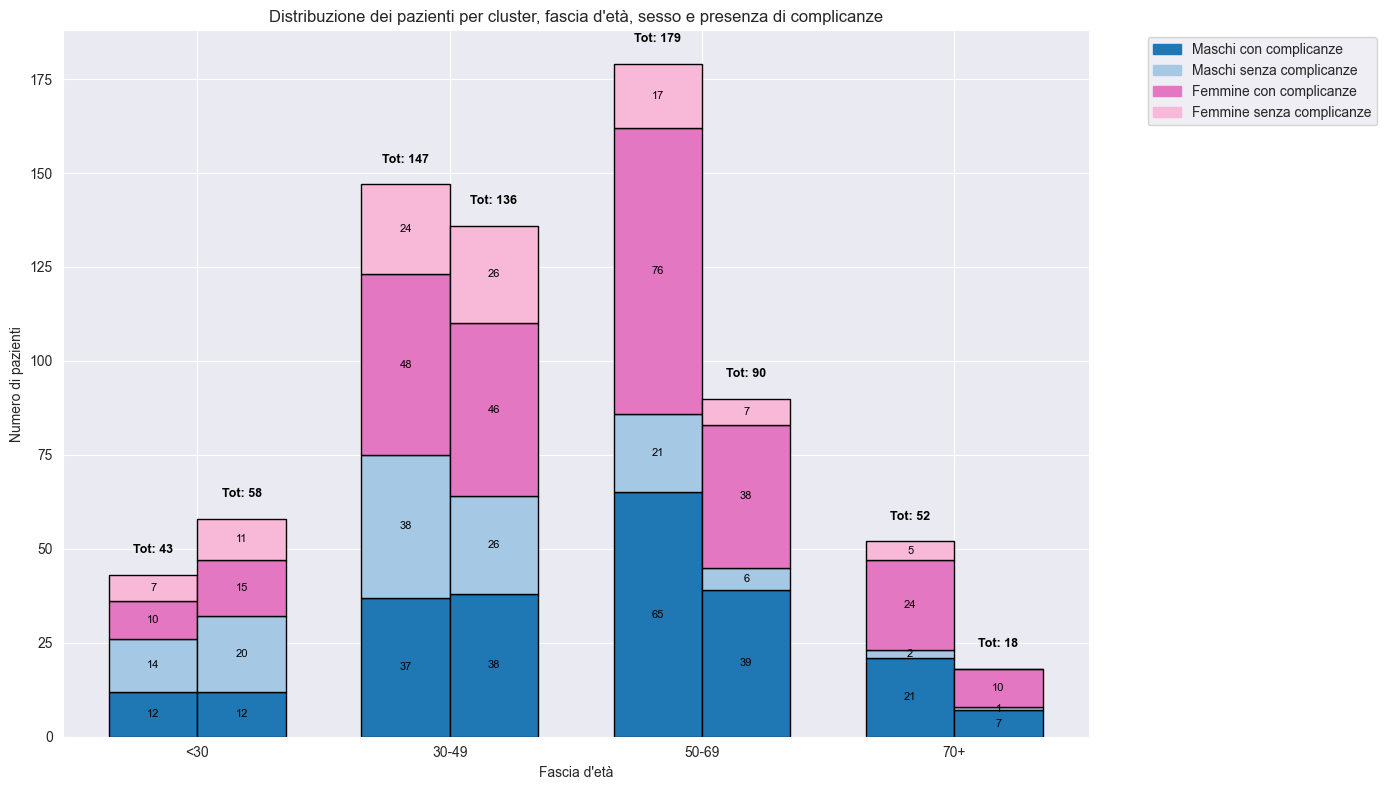

Mean | init=random, n_init=10, max_iter=100, tol=0.001, algo=elkan -> silhouette=0.111, ARI=0.001
Confusion Matrix:
 [[128  97]
 [293 205]]


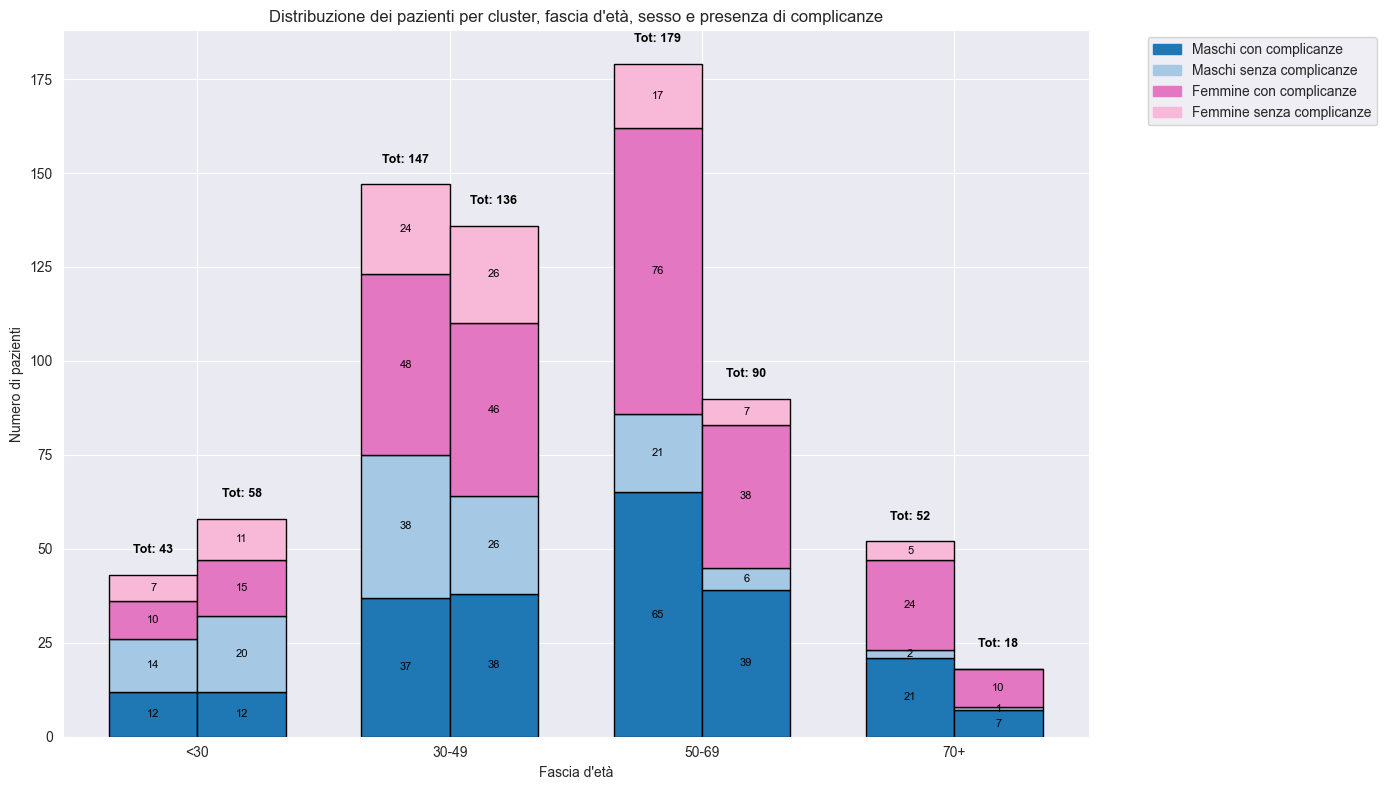

Mean | init=random, n_init=10, max_iter=300, tol=0.001, algo=lloyd -> silhouette=0.111, ARI=0.001
Confusion Matrix:
 [[128  97]
 [293 205]]


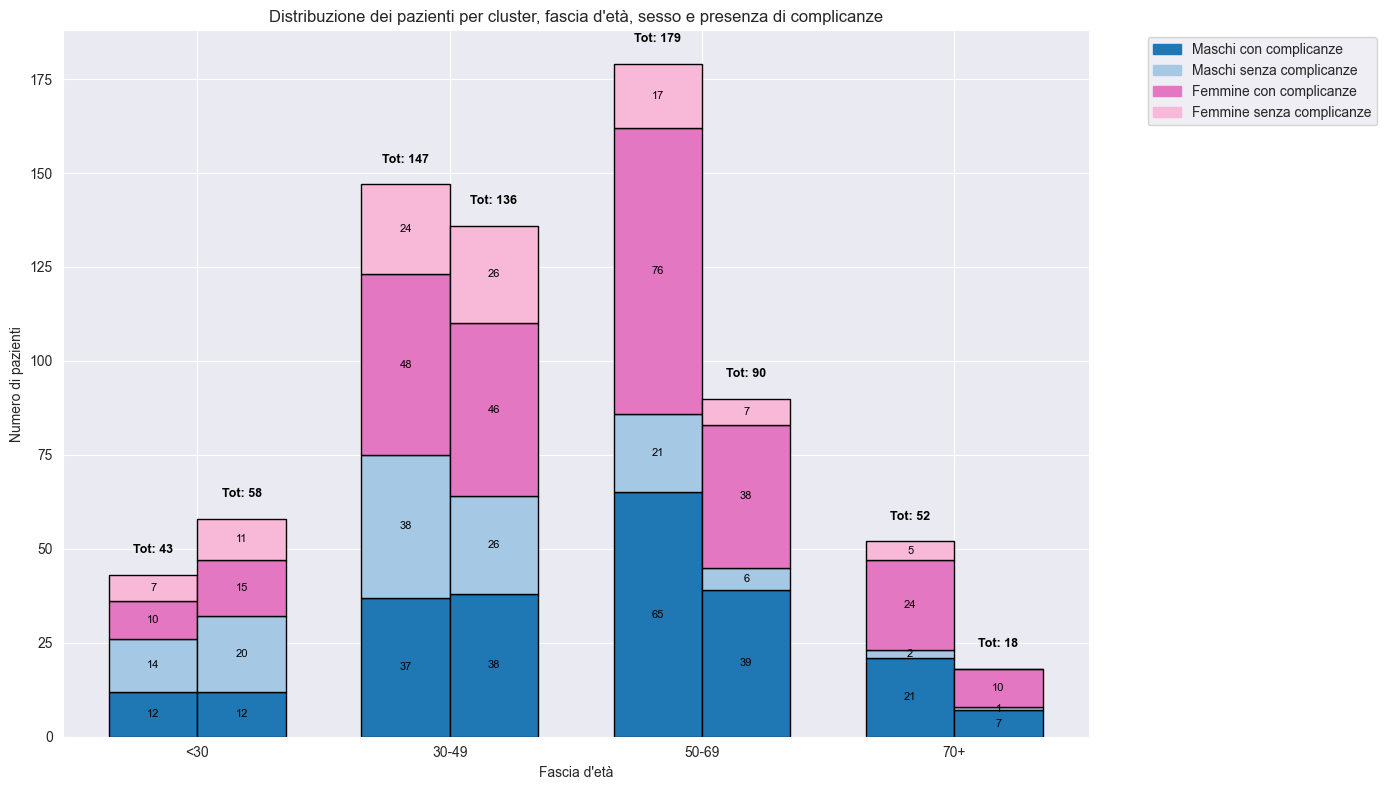

Mean | init=random, n_init=10, max_iter=300, tol=0.001, algo=elkan -> silhouette=0.111, ARI=0.001
Confusion Matrix:
 [[128  97]
 [293 205]]


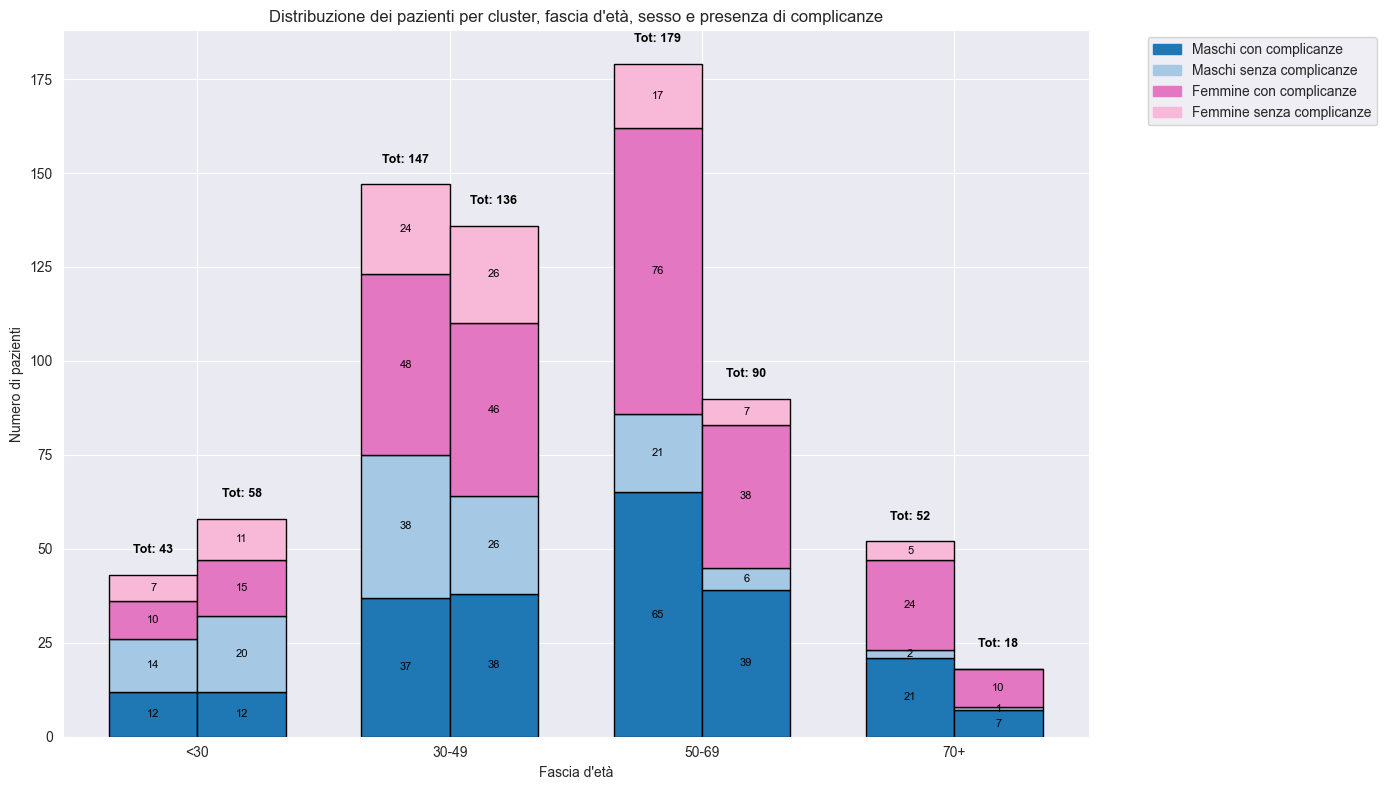

Mean | init=random, n_init=20, max_iter=100, tol=0.001, algo=lloyd -> silhouette=0.111, ARI=0.001
Confusion Matrix:
 [[128  97]
 [293 205]]


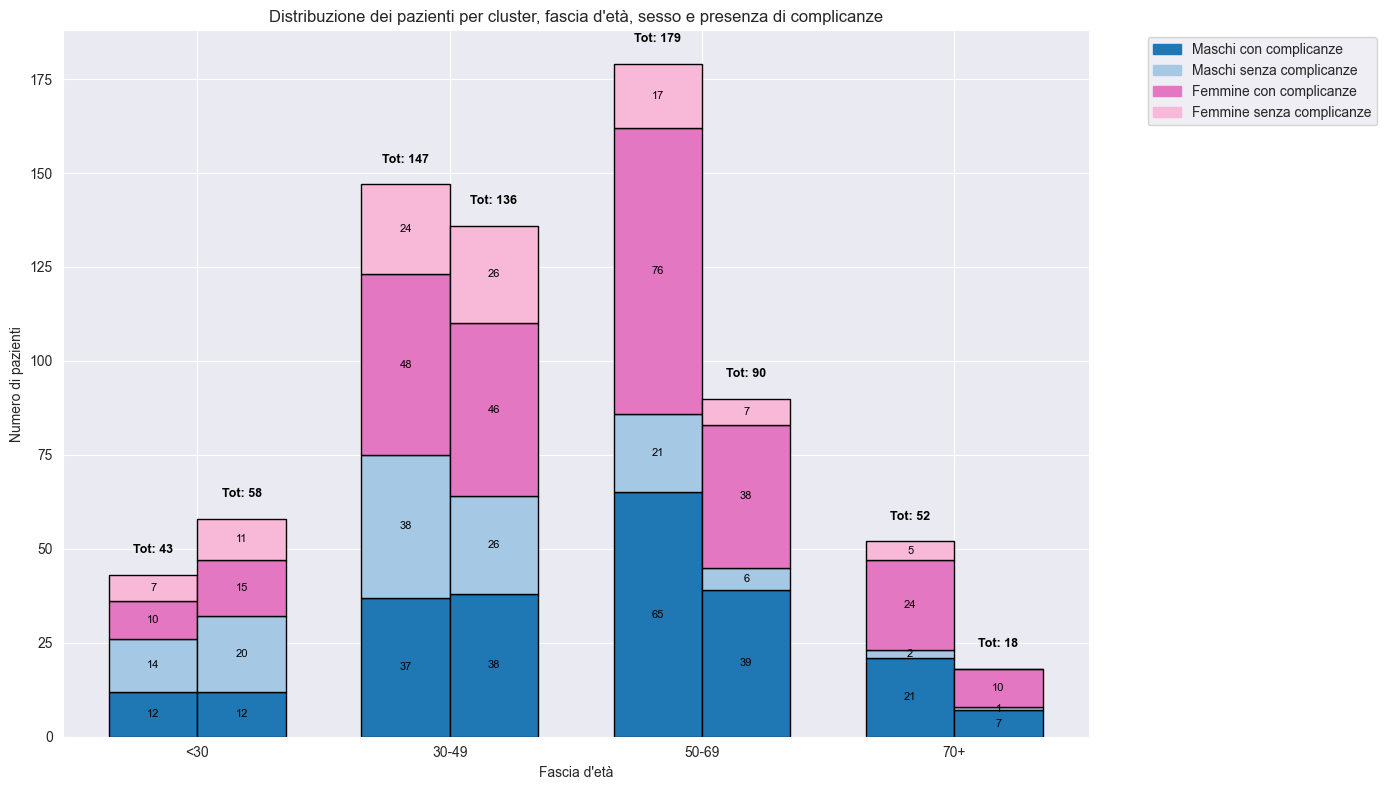

Mean | init=random, n_init=20, max_iter=100, tol=0.001, algo=elkan -> silhouette=0.111, ARI=0.001
Confusion Matrix:
 [[128  97]
 [293 205]]


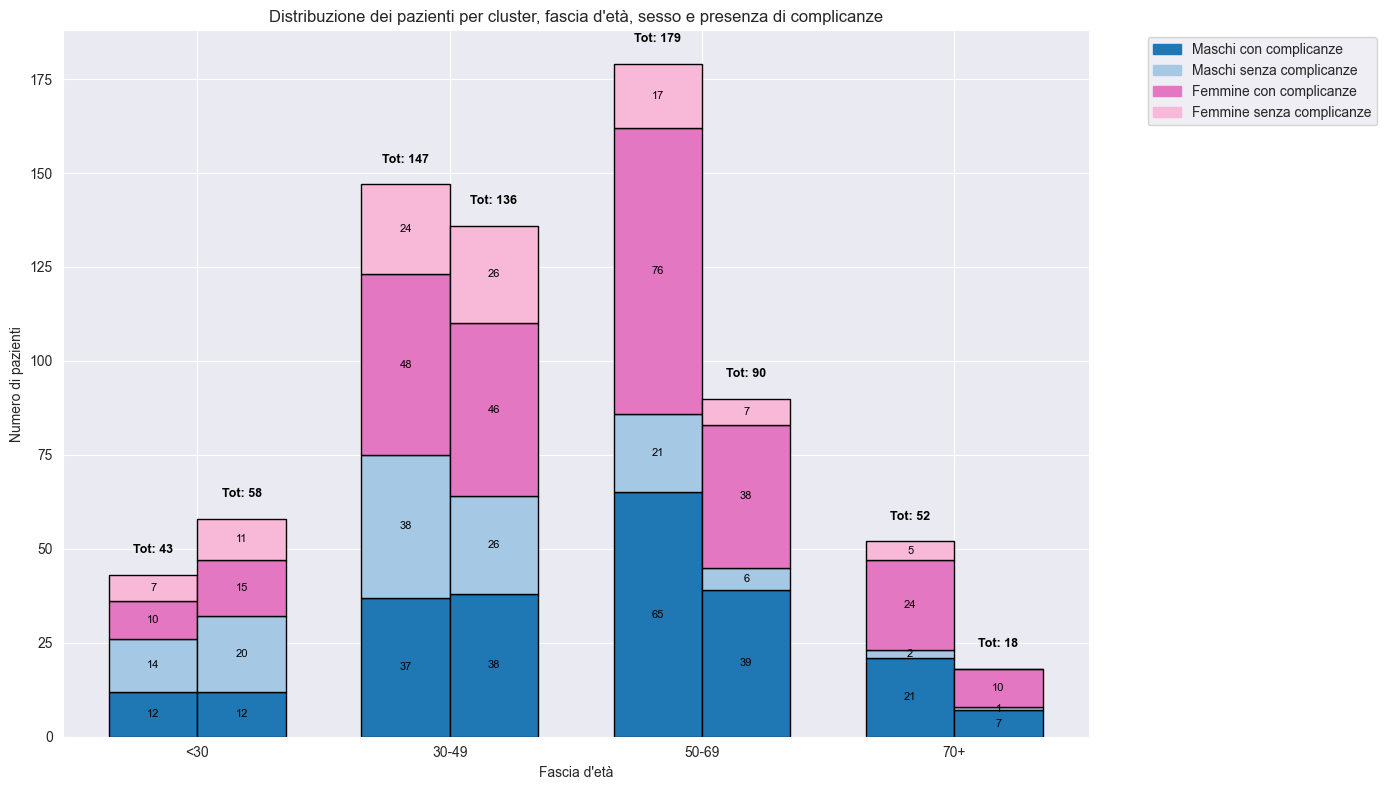

Mean | init=random, n_init=20, max_iter=300, tol=0.001, algo=lloyd -> silhouette=0.111, ARI=0.001
Confusion Matrix:
 [[128  97]
 [293 205]]


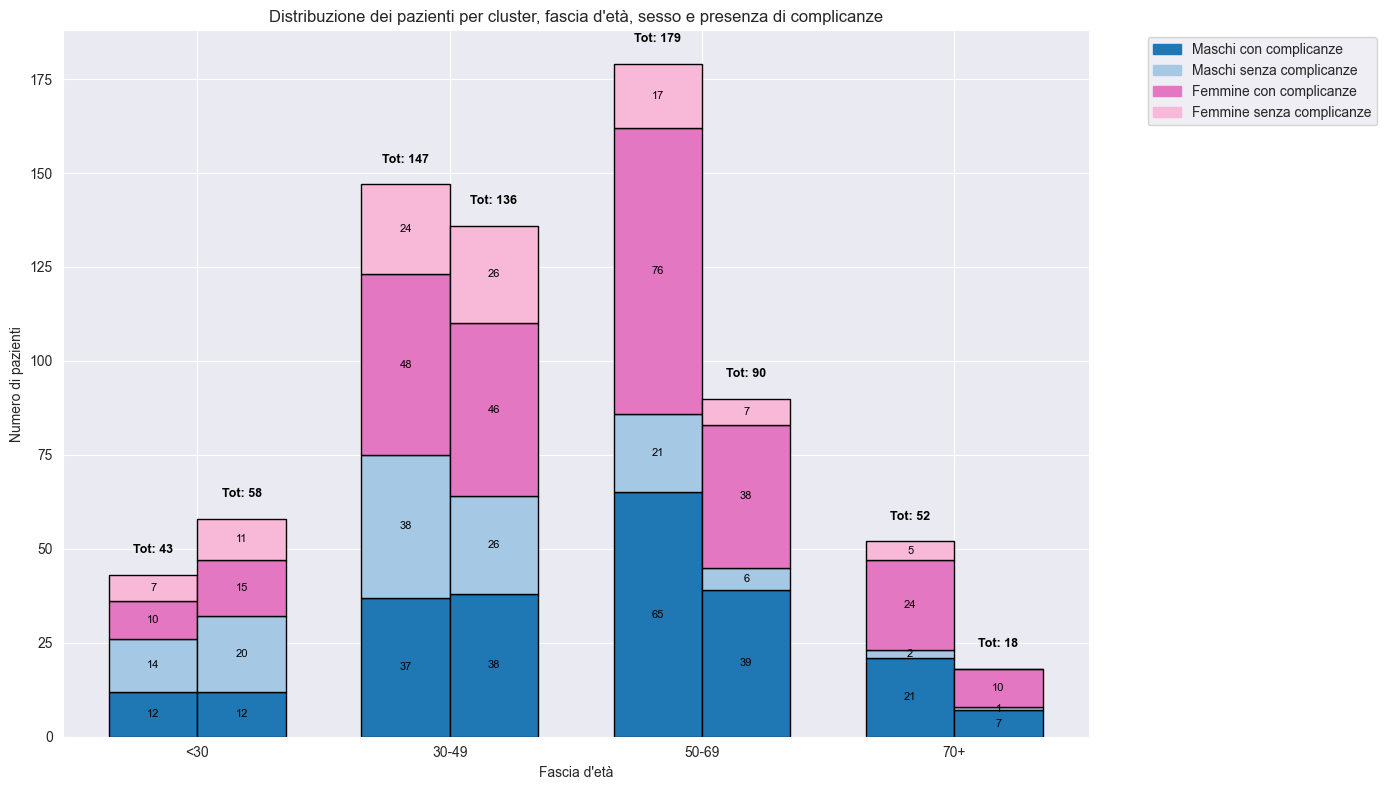

Mean | init=random, n_init=20, max_iter=300, tol=0.001, algo=elkan -> silhouette=0.111, ARI=0.001
Confusion Matrix:
 [[128  97]
 [293 205]]


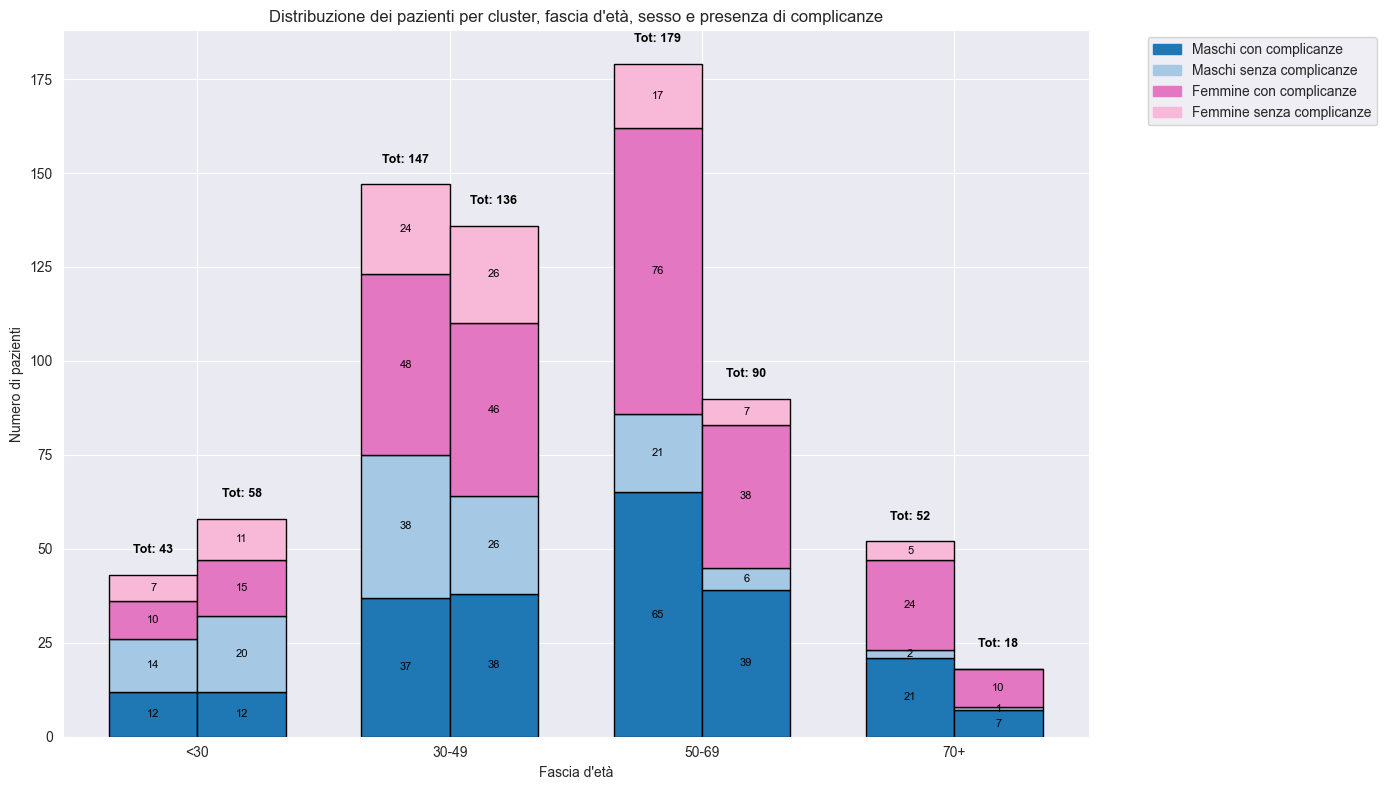

In [13]:
#GRAFICI DEI CLUSTER MIGLIORI

import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("Excel/Clustering.csv")

X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# Definisci i quattro imputatori
imputers = {
    # Sostituisce ogni valore mancante con la media aritmetica della colonna
    "Mean":    SimpleImputer(strategy="mean"),

    # Sostituisce ogni valore mancante con la mediana (valore centrale) della colonna,
    "Median":  SimpleImputer(strategy="median"),

    # Per ogni riga con missing, calcola i k (=5) pazienti più “simili” sulle altre feature
    # e sostituisce i NaN con la media dei valori corrispondenti di quei vicini
    "KNN":     KNNImputer(n_neighbors=5),

     # Imputa in modo iterativo (MICE):
    # 1) Inizializza i NaN (es. con la media)
    # 2) Per ogni colonna con missing, allena un modello sulle altre variabili per prevedere i NaN
    # 3) Ripete la procedura a catena per max_iter volte, migliorando progressivamente le stime
    "MICE":    IterativeImputer(max_iter=10, random_state=42)
}

# 4) Griglia di iperparametri per KMeans
param_grid = {
    'n_clusters': [2],              # fisso a 2
    'init':       ['k-means++', 'random'],
    'n_init':     [10, 20],
    'max_iter':   [100, 300],
    'tol':        [1e-4, 1e-3],
    'algorithm':  ['lloyd', 'elkan']
}

# 5) Funzione di valutazione
def evaluate(imputer_name, imputer, params):
    # a) Imputa i dati mancanti con il metodo scelto
    X_imp = imputer.fit_transform(X)
    # b) Standardizzazione
    X_scaled = StandardScaler().fit_transform(X_imp)
    # c) Configura e applica KMeans
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        init=params['init'],
        n_init=params['n_init'],
        max_iter=params['max_iter'],
        tol=params['tol'],
        algorithm=params['algorithm'],
        random_state=42
    )
    clusters = kmeans.fit_predict(X_scaled)
    # --- Statistiche demografiche e diagnostici per cluster ---
    df_tmp = df.copy()
    df_tmp['Cluster'] = clusters

    # Fasce d'età
    bins   = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '70+']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    # Conta i diagnosi per cluster × age group × sesso
    diag_counts = (
        df_tmp
        .groupby(['Cluster', 'AgeGroup', 'Sex'], observed=True)['Has_Diagnostics']
        .value_counts()
        .unstack(fill_value=0)
        .rename(columns={0: 'No_Dx', 1: 'Yes_Dx'})
    )
    # print(f"\n>> Diagnosi (Has_Diagnostics) per cluster, fasce d'età e sesso:")
    # print(diag_counts)
    # --------------------------------------------------------------


    # d) Metriche
    sil = silhouette_score(X_scaled, clusters)
    ari = adjusted_rand_score(y, clusters)
    cm  = confusion_matrix(y, clusters)
    return sil, ari, cm

import matplotlib.pyplot as plt
import numpy as np

# Funzione per generare il grafico
def plot_cluster_demographics(df_tmp):
    # Creazione delle fasce d'età
    bins = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '70+']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    # Preparazione dei dati per il plot
    cluster_data = []
    for cluster in [0, 1]:
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]

        age_counts = []
        for age_group in labels:
            age_df = cluster_df[cluster_df['AgeGroup'] == age_group]

            # Maschi con complicanze
            male_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 1)])
            # Maschi senza complicanze
            male_no_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 0)])
            # Femmine con complicanze
            female_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 1)])
            # Femmine senza complicanze
            female_no_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 0)])

            age_counts.append({
                'Male_Dx': male_dx,
                'Male_NoDx': male_no_dx,
                'Female_Dx': female_dx,
                'Female_NoDx': female_no_dx,
                'Total': male_dx + male_no_dx + female_dx + female_no_dx
            })

        cluster_data.append(age_counts)

    # Creazione del grafico
    fig, ax = plt.subplots(figsize=(14, 8))

    # Definizione dei colori
    colors = {
        'Male_Dx': '#1f77b4',      # Blu scuro
        'Male_NoDx': '#a5c8e4',    # Blu chiaro
        'Female_Dx': '#e377c2',    # Rosa scuro
        'Female_NoDx': '#f8b8d8'   # Rosa chiaro
    }

    bar_width = 0.35
    x = np.arange(len(labels))

    for i, cluster in enumerate([0, 1]):
        # Posizioni delle barre per ogni cluster
        positions = x + i * bar_width

        # Creazione delle barre stackate per ogni gruppo
        bottom = np.zeros(len(labels))

        # Lista per memorizzare le posizioni e i valori delle etichette
        label_positions = []
        label_values = []

        for segment in ['Male_Dx', 'Male_NoDx', 'Female_Dx', 'Female_NoDx']:
            counts = [cluster_data[cluster][j][segment] for j in range(len(labels))]
            ax.bar(positions, counts, bar_width, bottom=bottom,
                   color=colors[segment], edgecolor='black',
                   label=f'Cluster {cluster} {segment}' if i == 0 else "")

            # Aggiungi etichette per ogni segmento
            for j, count in enumerate(counts):
                if count > 0:  # Mostra solo etichette per valori > 0
                    ax.text(positions[j], bottom[j] + count/2, str(count),
                            ha='center', va='center', color='black', fontsize=8)

            bottom += counts

        # Aggiungi etichetta con il totale per ogni cluster e fascia d'età
        for j in range(len(labels)):
            total = cluster_data[cluster][j]['Total']
            ax.text(positions[j], bottom[j] + 5, f'Tot: {total}',
                    ha='center', va='bottom', color='black', fontsize=9, fontweight='bold')

    # Configurazione dell'asse x
    ax.set_xticks(x + bar_width/2)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Fascia d\'età')
    ax.set_ylabel('Numero di pazienti')
    ax.set_title('Distribuzione dei pazienti per cluster, fascia d\'età, sesso e presenza di complicanze')

    # Creazione della legenda
    handles = [
        plt.Rectangle((0,0),1,1, color='#1f77b4', label='Maschi con complicanze'),
        plt.Rectangle((0,0),1,1, color='#a5c8e4', label='Maschi senza complicanze'),
        plt.Rectangle((0,0),1,1, color='#e377c2', label='Femmine con complicanze'),
        plt.Rectangle((0,0),1,1, color='#f8b8d8', label='Femmine senza complicanze'),
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


results = []
# Modifica il loop principale per chiamare la funzione di plotting quando trova l'ARI desiderato
for imp_name, imp in imputers.items():
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                for tol in param_grid['tol']:
                    for algo in param_grid['algorithm']:
                        params = {
                            'n_clusters': 2,
                            'init':       init,
                            'n_init':     n_init,
                            'max_iter':   max_iter,
                            'tol':        tol,
                            'algorithm':  algo
                        }
                        sil, ari, cm = evaluate(imp_name, imp, params)
                        results.append({
                            'Imputer': imp_name,
                            **params,
                            'Silhouette': sil,
                            'ARI': ari,
                            'ConfusionMatrix': cm
                        })
                        if ari == 0.0012036242459496649:
                            print(
                                f"{imp_name} | init={init}, n_init={n_init}, "
                                f"max_iter={max_iter}, tol={tol}, algo={algo} "
                                f"-> silhouette={sil:.3f}, ARI={ari:.3f}"
                            )
                            print("Confusion Matrix:\n", cm)

                            # Prepara i dati per il plotting
                            X_imp = imp.fit_transform(X)
                            X_scaled = StandardScaler().fit_transform(X_imp)
                            kmeans = KMeans(
                                n_clusters=params['n_clusters'],
                                init=params['init'],
                                n_init=params['n_init'],
                                max_iter=params['max_iter'],
                                tol=params['tol'],
                                algorithm=params['algorithm'],
                                random_state=42
                            )
                            clusters = kmeans.fit_predict(X_scaled)
                            df_tmp = df.copy()
                            df_tmp['Cluster'] = clusters

                            # Genera il grafico
                            plot_cluster_demographics(df_tmp)


>>> Analisi ANOVA tra cluster (feature ordinati per significatività):
                               Feature  Cluster0_Mean  Cluster1_Mean  Cluster0_Std  Cluster1_Std  ANOVA_p_value
1                          %TIR_last3m       0.606039      -0.844842      0.661347      0.747361  1.952846e-114
2                       %TARLV2_last3m      -0.557944       0.777797      0.397675      1.065197   3.570252e-91
3          Glycated hemoglobin (A1c)_1      -0.464192       0.647103      0.587729      1.092420   6.388734e-58
4                       %TARLV1_last3m      -0.448529       0.625268      0.872137      0.813812   1.650552e-53
5                            Glucose_1      -0.357067       0.497766      0.763838      1.074795   1.609890e-32
6                       %TBRLV1_last3m       0.273672      -0.381510      1.130031      0.603271   4.943630e-19
7                             Sodium_1       0.273341      -0.381049      0.958139      0.930008   5.478742e-19
8                                

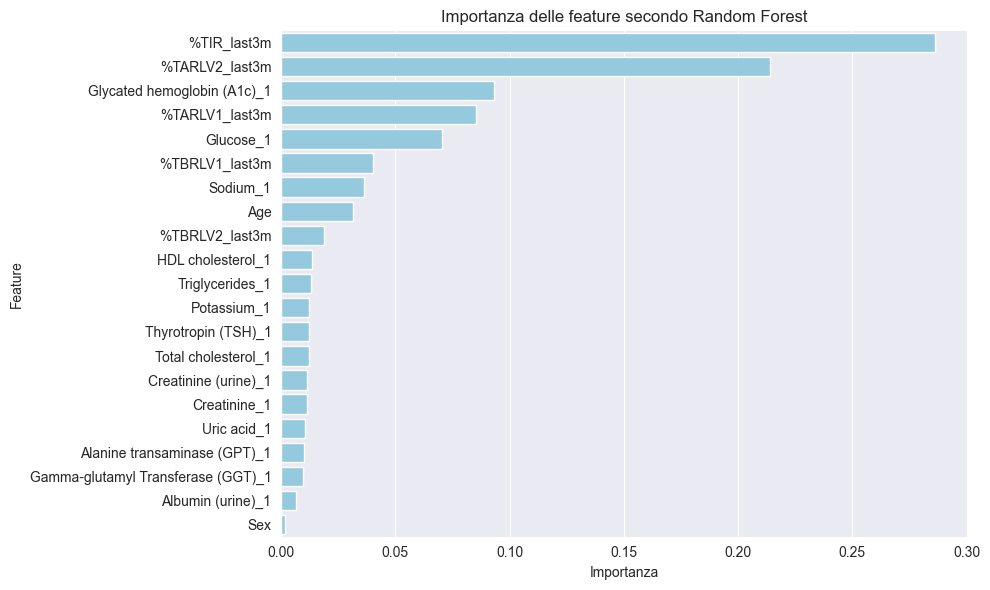

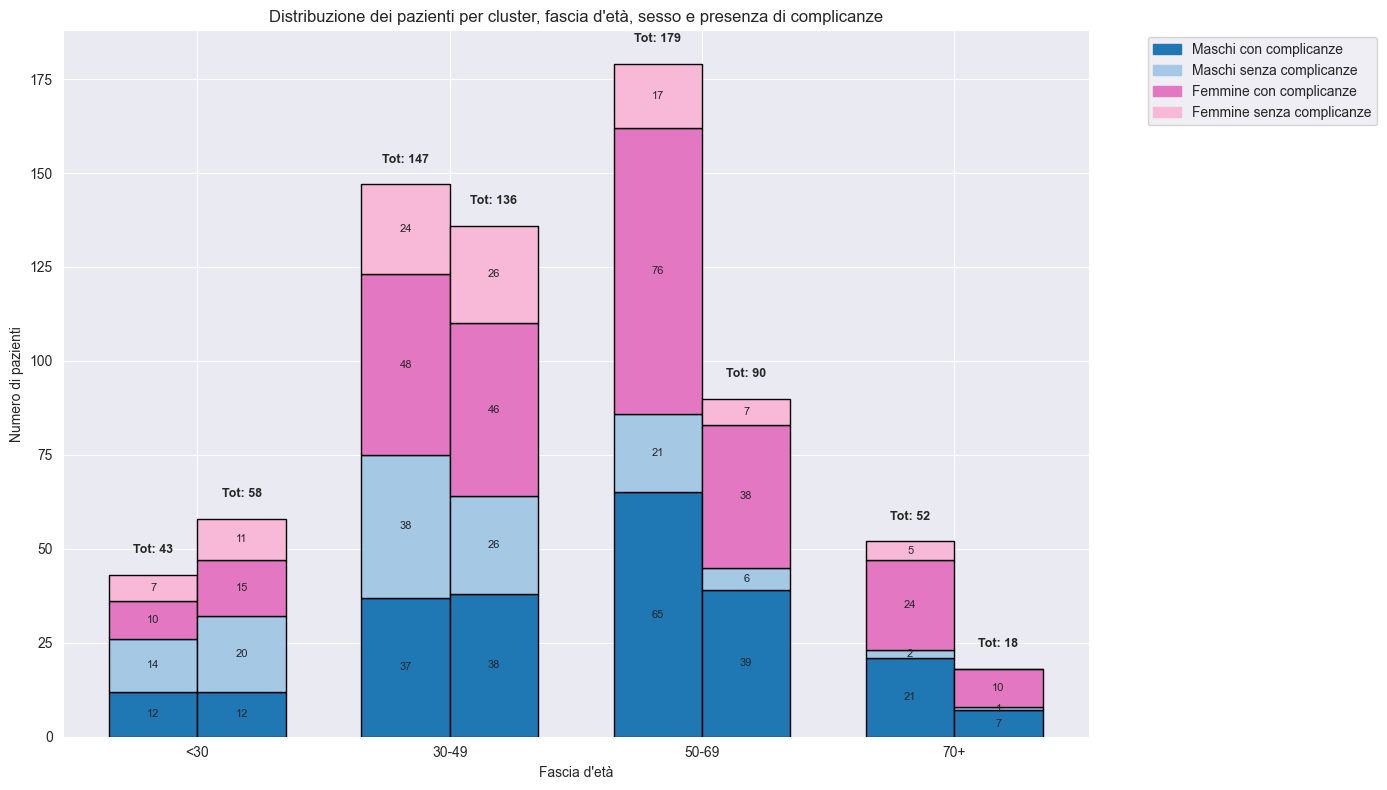

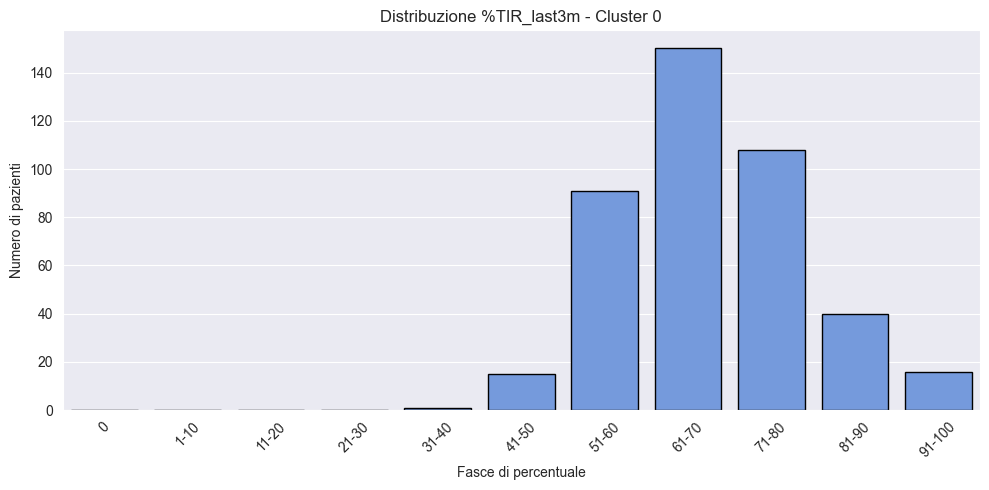

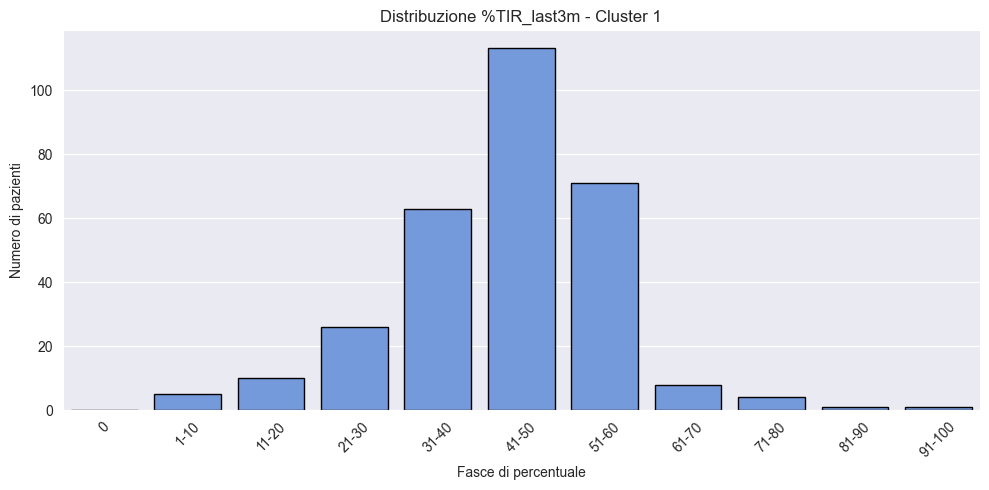

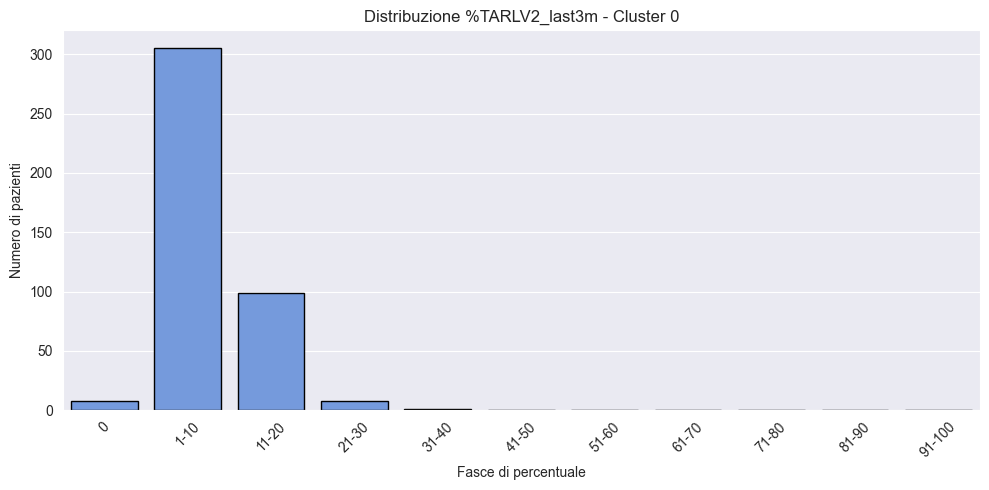

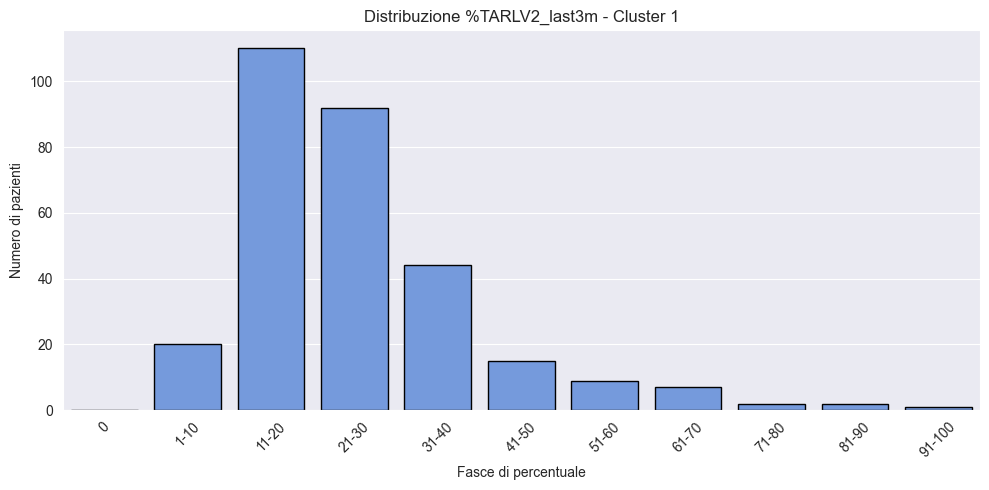

In [30]:
#ANALISI NEL DETTAGLIO DEL SINGOLO CLUSTER MIGLIORE OTTENUTO DA KMEANS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import f_oneway

# 1. Caricamento dei dati
df = pd.read_csv("Excel/Clustering.csv")
X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# 2. Imputazione dei valori mancanti (media)
imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)

# 3. Standardizzazione
X_scaled = StandardScaler().fit_transform(X_imp)

# 4. KMeans clustering
kmeans = KMeans(
    n_clusters=2,
    init='random',
    n_init=10,
    max_iter=100,
    tol=0.001,
    algorithm='lloyd',
    random_state=42
)
clusters = kmeans.fit_predict(X_scaled)

# 5. Aggiunta cluster al DataFrame
df_tmp = df.copy()
df_tmp['Cluster'] = clusters

# 6. Analisi delle feature per cluster (media, std, ANOVA) Analysis of Variance per vedere se la media delle features e' significativamente diversa tra i due cluster
feature_names = X.columns
summary = []


#Per ogni feature del dataset viene calcolata la media e la deviazione standard nei due cluster e il valore p del test ANOVA
#Se p > 0.05 allora la differenza tra le media nei due cluster non e' significativa, altrimenti  e' significativa
for i, feature in enumerate(feature_names):
    cluster_0 = X_scaled[clusters == 0, i]
    cluster_1 = X_scaled[clusters == 1, i]
    stat, p = f_oneway(cluster_0, cluster_1)
    summary.append({
        'Feature': feature,
        'Cluster0_Mean': np.mean(cluster_0),
        'Cluster1_Mean': np.mean(cluster_1),
        'Cluster0_Std': np.std(cluster_0),
        'Cluster1_Std': np.std(cluster_1),
        'ANOVA_p_value': p
    })

df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values("ANOVA_p_value").reset_index(drop=True)
df_summary.index = df_summary.index + 1  # Indici da 1 a N

print("\n>>> Analisi ANOVA tra cluster (feature ordinati per significatività):")
print(df_summary.to_string())


# 7. Feature Importance con Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, clusters)
importances = rf.feature_importances_
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# 8. Plot delle feature più importanti
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, color='skyblue')

plt.title('Importanza delle feature secondo Random Forest')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 9. Funzione per il grafico demografico
def plot_cluster_demographics(df_tmp):
    bins = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '70+']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    cluster_data = []
    for cluster in [0, 1]:
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]
        age_counts = []
        for age_group in labels:
            age_df = cluster_df[cluster_df['AgeGroup'] == age_group]
            male_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 1)])
            male_no_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 0)])
            female_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 1)])
            female_no_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 0)])
            age_counts.append({
                'Male_Dx': male_dx,
                'Male_NoDx': male_no_dx,
                'Female_Dx': female_dx,
                'Female_NoDx': female_no_dx,
                'Total': male_dx + male_no_dx + female_dx + female_no_dx
            })
        cluster_data.append(age_counts)

    fig, ax = plt.subplots(figsize=(14, 8))
    colors = {
        'Male_Dx': '#1f77b4',
        'Male_NoDx': '#a5c8e4',
        'Female_Dx': '#e377c2',
        'Female_NoDx': '#f8b8d8'
    }

    bar_width = 0.35
    x = np.arange(len(labels))
    for i, cluster in enumerate([0, 1]):
        positions = x + i * bar_width
        bottom = np.zeros(len(labels))
        for segment in ['Male_Dx', 'Male_NoDx', 'Female_Dx', 'Female_NoDx']:
            counts = [cluster_data[cluster][j][segment] for j in range(len(labels))]
            ax.bar(positions, counts, bar_width, bottom=bottom, color=colors[segment], edgecolor='black')
            for j, count in enumerate(counts):
                if count > 0:
                    ax.text(positions[j], bottom[j] + count/2, str(count), ha='center', va='center', fontsize=8)
            bottom += counts
        for j in range(len(labels)):
            total = cluster_data[cluster][j]['Total']
            ax.text(positions[j], bottom[j] + 5, f'Tot: {total}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Fascia d\'età')
    ax.set_ylabel('Numero di pazienti')
    ax.set_title('Distribuzione dei pazienti per cluster, fascia d\'età, sesso e presenza di complicanze')

    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_Dx'], label='Maschi con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_NoDx'], label='Maschi senza complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_Dx'], label='Femmine con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_NoDx'], label='Femmine senza complicanze'),
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# 10. Mostra il grafico demografico
plot_cluster_demographics(df_tmp)


# 11. Istogrammi separati per %TIR_last3m e %TARLV2_last3m


# 2 ISTOGRAMMI
# # Colonne target
# features = ['%TIR_last3m', '%TARLV2_last3m']
#
# # Definizione fasce
# bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
#
# for feature in features:
#     # Crea la colonna con le fasce
#     df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins, labels=labels, include_lowest=True, right=True)
#
#     # Conta i pazienti per cluster e fascia
#     counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')
#     counts.rename(columns={f'{feature}_bin': 'Fascia'}, inplace=True)
#
#     # Plot
#     plt.figure(figsize=(12, 6))
#     sns.barplot(data=counts, x='Fascia', y='Count', hue='Cluster', palette='Set2', dodge=True)
#
#     plt.title(f'Distribuzione pazienti per fasce di percentuale - {feature}')
#     plt.xlabel('Fasce di percentuale')
#     plt.ylabel('Numero di pazienti')
#     plt.legend(title='Cluster')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()



# 4 ISTOGRAMMI
# Colonne target
features = ['%TIR_last3m', '%TARLV2_last3m']

# Definizione fasce
bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Crea le colonne binned per ogni feature
for feature in features:
    df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins, labels=labels, include_lowest=True, right=True)

# Per ogni combinazione di feature e cluster, plottiamo un istogramma
for feature in features:
    for cluster in [0, 1]:
        # Filtra solo i dati del cluster corrente
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]

        # Conta i pazienti nelle fasce
        counts = cluster_df[f'{feature}_bin'].value_counts().sort_index()

        # Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(x=counts.index, y=counts.values, color='cornflowerblue', edgecolor='black')

        plt.title(f'Distribuzione {feature} - Cluster {cluster}')
        plt.xlabel('Fasce di percentuale')
        plt.ylabel('Numero di pazienti')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()




In [7]:
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    confusion_matrix,
    silhouette_score,
    accuracy_score,
    precision_score
)

# 1. Caricamento dataset
df = pd.read_csv("Excel/Clustering.csv")
X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# 2. Imputatori
imputers = {
    # Sostituisce ogni valore mancante con la media aritmetica della colonna
    "Mean":    SimpleImputer(strategy="mean"),
    # Sostituisce ogni valore mancante con la mediana (valore centrale) della colonna
    "Median":  SimpleImputer(strategy="median"),
    # KNN: media dei k=5 vicini per riga
    "KNN":     KNNImputer(n_neighbors=5),
    # MICE: imputazione iterativa
    "MICE":    IterativeImputer(max_iter=10, random_state=42)
}

# 3. Griglia di iperparametri per AgglomerativeClustering
linkages = ['ward', 'complete', 'average', 'single']
# per ogni linkage, definiamo i metrici ammessi
valid_metrics = {
    'ward':     ['euclidean'],                    # ward richiede euclidea
    'complete': ['euclidean', 'manhattan', 'cosine'],
    'average':  ['euclidean', 'manhattan', 'cosine'],
    'single':   ['euclidean', 'manhattan', 'cosine']
}

# 4. Funzione di valutazione
def evaluate_agglomerative(imputer_name, imputer, n_clusters, linkage, metric):
    # a) Imputazione dei valori mancanti
    X_imp = imputer.fit_transform(X)
    # b) Standardizzazione
    X_scaled = StandardScaler().fit_transform(X_imp)
    # c) Clustering gerarchico agglomerativo
    agg = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage,
        metric=metric
    )
    clusters = agg.fit_predict(X_scaled)
    # d) Calcolo delle metriche
    sil   = silhouette_score(X_scaled, clusters)
    cm    = confusion_matrix(y, clusters)
    acc   = accuracy_score(y, clusters)
    prec  = precision_score(y, clusters, zero_division=0)
    return sil, cm, acc, prec

# 5. Loop su imputatori, linkage e metric
results = []
for imp_name, imp in imputers.items():
    for linkage in linkages:
        for metric in valid_metrics[linkage]:
            # fissiamo sempre n_clusters=2
            sil, cm, acc, prec = evaluate_agglomerative(
                imp_name, imp,
                n_clusters=2,
                linkage=linkage,
                metric=metric
            )
            results.append({
                'Imputer': imp_name,
                'Linkage': linkage,
                'Metric':  metric,
                'Silhouette': sil,
                'Accuracy':   acc,
                'Precision':  prec,
                'ConfusionMatrix': cm
            })
            print(f"{imp_name} | linkage={linkage}, metric={metric} "
                  f"-> silhouette={sil:.3f}, accuracy={acc:.3f}, precision={prec:.3f}")
            print(cm)


Mean | linkage=ward, metric=euclidean -> silhouette=0.809, accuracy=0.313, precision=1.000
[[225   0]
 [497   1]]
Mean | linkage=complete, metric=euclidean -> silhouette=0.809, accuracy=0.313, precision=1.000
[[225   0]
 [497   1]]
Mean | linkage=complete, metric=manhattan -> silhouette=0.809, accuracy=0.313, precision=1.000
[[225   0]
 [497   1]]
Mean | linkage=complete, metric=cosine -> silhouette=0.055, accuracy=0.416, precision=0.652
[[138  87]
 [335 163]]
Mean | linkage=average, metric=euclidean -> silhouette=0.809, accuracy=0.313, precision=1.000
[[225   0]
 [497   1]]
Mean | linkage=average, metric=manhattan -> silhouette=0.809, accuracy=0.313, precision=1.000
[[225   0]
 [497   1]]
Mean | linkage=average, metric=cosine -> silhouette=0.092, accuracy=0.427, precision=0.706
[[165  60]
 [354 144]]
Mean | linkage=single, metric=euclidean -> silhouette=0.809, accuracy=0.313, precision=1.000
[[225   0]
 [497   1]]
Mean | linkage=single, metric=manhattan -> silhouette=0.809, accuracy=0

In [25]:
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import (
    confusion_matrix,
    silhouette_score,
    accuracy_score,
    precision_score
)

# 1. Caricamento dataset
df = pd.read_csv("Excel/Clustering.csv")
X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# 2. Imputatori
imputers = {
    "Mean":    SimpleImputer(strategy="mean"),
    "Median":  SimpleImputer(strategy="median"),
    "KNN":     KNNImputer(n_neighbors=5),
    "MICE":    IterativeImputer(max_iter=10, random_state=42)
}

# 3. Funzione di valutazione per Mean Shift
def evaluate_meanshift(imputer_name, imputer):
    # a) Imputazione dei valori mancanti
    X_imp = imputer.fit_transform(X)
    # b) Standardizzazione
    X_scaled = StandardScaler().fit_transform(X_imp)
    meanshift = MeanShift()
    clusters = meanshift.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, clusters)
    cm = confusion_matrix(y, clusters)
    acc = accuracy_score(y, clusters)
    prec = precision_score(y, clusters, average='macro', zero_division=0)

    # -- Analisi cluster vs Has_Diagnostics --
    df_result = df.copy()
    df_result['cluster'] = clusters
    contingency_table = pd.crosstab(df_result['cluster'], df_result['Has_Diagnostics'],
                                    rownames=['Cluster'], colnames=['Has_Diagnostics'])

    print(f"\nImputer: {imputer_name}")
    print("Tabella di contingenza tra cluster e complicanze (Has_Diagnostics):")
    print(contingency_table)

    # Calcolo percentuale di complicanze in ogni cluster
    percent_complicanze = contingency_table[1] / contingency_table.sum(axis=1) * 100
    print("\nPercentuale di pazienti con complicanze in ogni cluster:")
    print(percent_complicanze)

    # Numero pazienti per cluster
    print("\nNumero di pazienti per cluster:")
    print(contingency_table.sum(axis=1))

    return sil, cm, acc, prec

# 4. Loop su imputatori per Mean Shift
results_meanshift = []
for imp_name, imp in imputers.items():
    sil, cm, acc, prec = evaluate_meanshift(imp_name, imp)
    results_meanshift.append({
        'Imputer': imp_name,
        'Silhouette': sil,
        'Accuracy': acc,
        'Precision': prec,
        'ConfusionMatrix': cm
    })
    print(f"{imp_name} | Mean Shift -> silhouette={sil:.3f}, accuracy={acc:.3f}, precision={prec:.3f}")
    print(cm)



Imputer: Mean
Tabella di contingenza tra cluster e complicanze (Has_Diagnostics):
Has_Diagnostics    0    1
Cluster                  
0                216  468
1                  0    2
2                  0    3
3                  0    2
4                  0    1
5                  1    0
6                  0    3
7                  0    1
8                  0    1
9                  0    1
10                 1    0
11                 1    0
12                 0    1
13                 1    0
14                 0    3
15                 0    1
16                 0    3
17                 0    1
18                 3    2
19                 1    5
20                 1    0

Percentuale di pazienti con complicanze in ogni cluster:
Cluster
0      68.421053
1     100.000000
2     100.000000
3     100.000000
4     100.000000
5       0.000000
6     100.000000
7     100.000000
8     100.000000
9     100.000000
10      0.000000
11      0.000000
12    100.000000
13      0.000000
14    100.00000

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    confusion_matrix,
    silhouette_score,
    accuracy_score,
    precision_score
)

# 1. Caricamento dataset
df = pd.read_csv("Excel/Clustering.csv")
X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# 2. Imputatori
imputers = {
    "Mean":    SimpleImputer(strategy="mean"),
    "Median":  SimpleImputer(strategy="median"),
    "KNN":     KNNImputer(n_neighbors=5),
    "MICE":    IterativeImputer(max_iter=10, random_state=42)
}

# 3. Funzione di valutazione
def evaluate_dbscan(imputer_name, imputer, eps=0.5, min_samples=5):
    # a) Imputazione
    X_imp = imputer.fit_transform(X)
    # b) Standardizzazione
    X_scaled = StandardScaler().fit_transform(X_imp)
    # c) DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_scaled)

    # d) Etichette complete (incluso rumore)
    X_valid = X_scaled
    y_valid = y
    clusters_valid = clusters

    # e) Info cluster
    unique, counts = np.unique(clusters_valid, return_counts=True)
    cluster_info = dict(zip(unique, counts))

    # f) Valutazione
    if len(set(clusters_valid)) < 2:
        sil = np.nan
        acc = np.nan
        prec = np.nan
        cm = np.array([[0, 0], [0, 0]])
    else:
        sil = silhouette_score(X_valid, clusters_valid)
        acc = accuracy_score(y_valid, clusters_valid)
        prec = precision_score(y_valid, clusters_valid, average="macro", zero_division=0)
        cm = confusion_matrix(y_valid, clusters_valid)

    return sil, cm, acc, prec, len(set(clusters_valid)), cluster_info

# 4. Loop su eps e imputatori
eps_values = [1.0, 2.0, 3.0, 5.0, 10.0]
results = []

for eps in eps_values:
    print(f"\n========== eps = {eps} ==========")
    for imp_name, imp in imputers.items():
        sil, cm, acc, prec, n_clusters, cluster_info = evaluate_dbscan(imp_name, imp, eps=eps, min_samples=3)
        results.append({
            'Eps': eps,
            'Imputer': imp_name,
            'Silhouette': sil,
            'Accuracy': acc,
            'Precision': prec,
            'ConfusionMatrix': cm,
            'NumClusters': n_clusters,
            'ClusterDistribution': cluster_info
        })
        print(f"{imp_name} | eps={eps} | n_clusters={n_clusters} -> silhouette={sil:.3f}, accuracy={acc}, precision={prec}")
        print("Cluster distribution:", cluster_info)
        print("Confusion Matrix:\n", cm)


========== eps = 1.0 ==========
Mean | eps=1.0 | n_clusters=1 -> silhouette=nan, accuracy=nan, precision=nan
Cluster distribution: {np.int64(-1): np.int64(723)}
Confusion Matrix:
 [[0 0]
 [0 0]]
Median | eps=1.0 | n_clusters=1 -> silhouette=nan, accuracy=nan, precision=nan
Cluster distribution: {np.int64(-1): np.int64(723)}
Confusion Matrix:
 [[0 0]
 [0 0]]
KNN | eps=1.0 | n_clusters=1 -> silhouette=nan, accuracy=nan, precision=nan
Cluster distribution: {np.int64(-1): np.int64(723)}
Confusion Matrix:
 [[0 0]
 [0 0]]
MICE | eps=1.0 | n_clusters=1 -> silhouette=nan, accuracy=nan, precision=nan
Cluster distribution: {np.int64(-1): np.int64(723)}
Confusion Matrix:
 [[0 0]
 [0 0]]

========== eps = 2.0 ==========
Mean | eps=2.0 | n_clusters=16 -> silhouette=-0.307, accuracy=0.0013831258644536654, precision=0.015625
Cluster distribution: {np.int64(-1): np.int64(640), np.int64(0): np.int64(4), np.int64(1): np.int64(4), np.int64(2): np.int64(6), np.int64(3): np.int64(12), np.int64(4): np.int6